In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Importar datos

In [2]:
# Clientes
clientes = 'C:/Users/PC/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/Documents/Reto/Datos originales/customers_sampled.csv'

# Productos
productos = 'C:/Users/PC/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/Documents/Reto/Datos originales/20230223_productos.csv'

# Ventas
ventas = 'C:/Users/PC/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/Documents/Reto/Datos originales/ventas.csv'

# Leer archivo
df_productos = pd.read_csv(productos)
df_clientes = pd.read_csv(clientes)
df_ventas = pd.read_csv(ventas, encoding = 'utf-8-sig')

In [3]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Material               793 non-null    int64 
 1   Material_desc          793 non-null    object
 2   Productos_Por_Empaque  793 non-null    int64 
 3   BrandPresRet           793 non-null    object
 4   ProdKey                793 non-null    object
 5   Brand                  793 non-null    object
 6   Presentation           793 non-null    object
 7   MLSize                 793 non-null    int64 
 8   Returnability          793 non-null    object
 9   Pack                   793 non-null    object
 10  Size                   793 non-null    object
 11  Flavor                 793 non-null    object
 12  Container              793 non-null    object
 13  Ncb                    793 non-null    int64 
 14  ProductType            793 non-null    object
 15  ProductCategory        

In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347110 entries, 0 to 2347109
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   CustomerId  int64  
 1   material    int64  
 2   calmonth    int64  
 3   uni_box     float64
dtypes: float64(1), int64(3)
memory usage: 71.6 MB


# Eliminar registros del 2019 de ventas 

In [5]:
df_ventas['Fecha'] = pd.to_datetime(df_ventas['calmonth'], format='%Y%m')

# Filtrar los registros que no son del año 2019
df_ventas = df_ventas[df_ventas['Fecha'].dt.year != 2019]


# Agrupación de clientes en df_ventas

In [6]:
df_ventas['Fecha'] = pd.to_datetime(df_ventas['calmonth'], format='%Y%m')

# Extraer el mes de la fecha
df_ventas['Mes'] = df_ventas['Fecha'].dt.month

# Crear un DataFrame agrupado por 'CustomerId' y 'material'
df_ventas_grouped = df_ventas.groupby(['CustomerId', 'material']).agg({
    'uni_box': 'sum',
    'Fecha': list
}).reset_index()

# Crear otro DataFrame con la suma de 'uni_box' por 'CustomerId' y 'Mes'
df_ventas_mes = df_ventas.groupby(['CustomerId', 'Mes'])['uni_box'].sum().unstack(fill_value=0).reset_index()

# Renombrar las columnas de los meses para que sean más descriptivas
df_ventas_mes.columns.name = None
df_ventas_mes = df_ventas_mes.rename(columns={i: f'mes_{i}' for i in range(1, 13)})

# Combinar los DataFrames para tener las columnas mensuales junto al DataFrame agrupado original
df_result = pd.merge(df_ventas_grouped, df_ventas_mes, on='CustomerId', how='left')

print(df_result)

        CustomerId  material   uni_box  \
0        499920078         1    1.5005   
1        499920078        24    8.9828   
2        499920078       100  686.8550   
3        499920078       101    6.3402   
4        499920078       121    4.2268   
...            ...       ...       ...   
227829   510838861      9207    0.1761   
227830   510838861      9346    1.4089   
227831   510838861     14324    3.5224   
227832   510839053       372   14.0896   
227833   510839053       424    1.2681   

                                                    Fecha     mes_1     mes_2  \
0                                   [2020-02-01 00:00:00]  455.2569  391.2761   
1       [2020-01-01 00:00:00, 2020-04-01 00:00:00, 202...  455.2569  391.2761   
2       [2020-01-01 00:00:00, 2020-02-01 00:00:00, 202...  455.2569  391.2761   
3       [2020-06-01 00:00:00, 2020-11-01 00:00:00, 202...  455.2569  391.2761   
4              [2020-01-01 00:00:00, 2020-02-01 00:00:00]  455.2569  391.2761   
...      

# Escalar uni_box por mes

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Separar las columnas que necesitan ser escaladas
mes_columns = [col for col in df_result.columns if 'mes_' in col]

# Crear una copia de las columnas originales para evitar errores de asignación
scaled_values = df_result[mes_columns].apply(lambda row: MinMaxScaler().fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1)

# Asignar los valores escalados de vuelta al DataFrame original por columnas
for i, col in enumerate(mes_columns):
    df_result[col] = scaled_values.apply(lambda x: x[i])
print(df_result)

df_ventas_grouped = df_result.copy()

        CustomerId  material   uni_box  \
0        499920078         1    1.5005   
1        499920078        24    8.9828   
2        499920078       100  686.8550   
3        499920078       101    6.3402   
4        499920078       121    4.2268   
...            ...       ...       ...   
227829   510838861      9207    0.1761   
227830   510838861      9346    1.4089   
227831   510838861     14324    3.5224   
227832   510839053       372   14.0896   
227833   510839053       424    1.2681   

                                                    Fecha     mes_1     mes_2  \
0                                   [2020-02-01 00:00:00]  0.455683  0.144194   
1       [2020-01-01 00:00:00, 2020-04-01 00:00:00, 202...  0.455683  0.144194   
2       [2020-01-01 00:00:00, 2020-02-01 00:00:00, 202...  0.455683  0.144194   
3       [2020-06-01 00:00:00, 2020-11-01 00:00:00, 202...  0.455683  0.144194   
4              [2020-01-01 00:00:00, 2020-02-01 00:00:00]  0.455683  0.144194   
...      

# K means para segmentar tipo de cliente según los uni_box comprados por mes de cada cliente

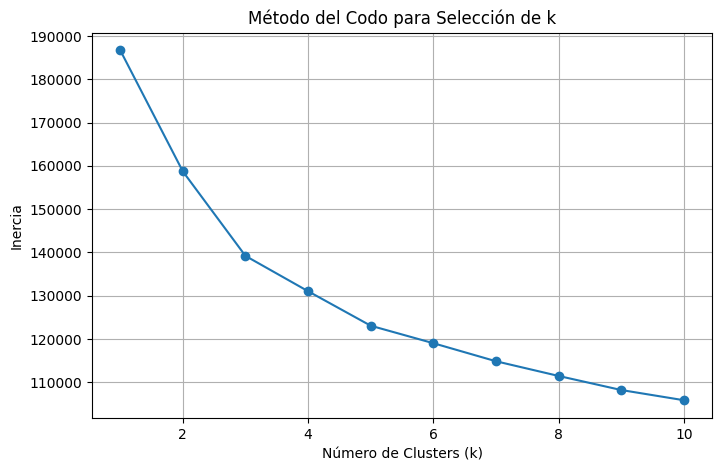

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Supongamos que queremos hacer clustering usando las siguientes columnas
columns_for_clustering = ['mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 
                          'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']

# Seleccionar las columnas específicas del DataFrame
X_clustering = df_ventas_grouped[columns_for_clustering]

# Calcular la inercia para diferentes valores de n_clusters
inertia = []
cluster_range = range(1, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

# Graficar la curva de codo
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Selección de k')
plt.grid(True)
plt.show()


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Supongamos que queremos hacer clustering usando las siguientes columnas
columns_for_clustering = ['mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 
                          'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']

# Seleccionar las columnas específicas del DataFrame
X_clustering = df_ventas_grouped[columns_for_clustering]

# Definir el modelo KMeans con un número específico de clusters (por ejemplo, 3)
kmeans = KMeans(n_clusters=5, random_state=42)

# Ajustar el modelo a los datos
kmeans.fit(X_clustering)

# Obtener los labels de los clusters
cluster_labels = kmeans.labels_

# Agregar los labels al DataFrame original para análisis posterior
df_ventas_grouped['Cluster'] = cluster_labels

# Crear columna de producto exitoso o no

In [10]:
# Función para verificar si las primeras 5 fechas son meses consecutivos
def primeros_cinco_meses_consecutivos(fechas):
    # Ordenar las fechas para asegurar el orden cronológico
    fechas = sorted(fechas)

    # Verificar que haya al menos 5 fechas
    if len(fechas) < 5:
        return 0

    # Tomar solo las primeras 5 fechas
    primeras_cinco = fechas[:5]

    # Verificar si las 5 fechas son meses consecutivos
    for i in range(4):  # Comparamos hasta la penúltima fecha
        # Calcular la diferencia en meses entre fechas consecutivas
        diff = (primeras_cinco[i + 1].year - primeras_cinco[i].year) * 12 + \
               (primeras_cinco[i + 1].month - primeras_cinco[i].month)

        # Si alguna diferencia no es de 1 mes, no son consecutivas
        if diff != 1:
            return 0

    # Si todas las diferencias fueron de 1 mes, devuelve 1
    return 1


# Aplicar la función al DataFrame para crear la nueva columna
df_ventas_grouped['Producto Exitoso'] = df_ventas_grouped['Fecha'].apply(primeros_cinco_meses_consecutivos)

# Calcular el porcentaje de 1's y 0's en la columna 'Producto Exitoso'
porcentajes = df_ventas_grouped['Producto Exitoso'].value_counts(normalize=True) * 100

porcentajes

Producto Exitoso
0    83.2119
1    16.7881
Name: proportion, dtype: float64

# Unir todos los dataframes

## Union de ventas_grouped y clientes

In [11]:
df_ventas_clientes = pd.merge(df_ventas_grouped, df_clientes, on='CustomerId', how='left')

df_ventas_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227834 entries, 0 to 227833
Columns: 224 entries, CustomerId to sub_canal_comercial
dtypes: float64(215), int32(1), int64(4), object(4)
memory usage: 388.5+ MB


## Union de df_ventas_clientes con productos

In [12]:
df_unido = pd.merge(df_ventas_clientes, df_productos, left_on='material', right_on='Material', how='left')

df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227834 entries, 0 to 227833
Columns: 246 entries, CustomerId to GlobalFlavor
dtypes: float64(219), int32(1), int64(4), object(22)
memory usage: 426.7+ MB


In [13]:
df_productos.columns

Index(['Material', 'Material_desc', 'Productos_Por_Empaque', 'BrandPresRet',
       'ProdKey', 'Brand', 'Presentation', 'MLSize', 'Returnability', 'Pack',
       'Size', 'Flavor', 'Container', 'Ncb', 'ProductType', 'ProductCategory',
       'SegAg', 'SegDet', 'GlobalCategory', 'GlobalSubcategory',
       'BrandGrouper', 'GlobalFlavor'],
      dtype='object')

# Eliminación de columnas innecesarias

In [14]:
# Eliminar columnas originales de df_clientes
df_unido = df_unido.drop([
 'pc_agr_300m',
 'pc_comercial_300m',
 'pc_generales_300m',
 'pc_habitacional_300m',
 'pc_habitacional_mixta_300m',
 'pc_industrial_300m',
 'pc_minero_300m',
 'pc_mixta_300m',
 'pc_negocios_300m',
 'pc_turismo_300m',
 'mov_domingo',
 'mov_lunes',
 'mov_martes',
 'mov_miercoles',
 'mov_jueves',
 'mov_viernes',
 'mov_sabado',
 'mov_8_00_9_59',
 'mov_10_00_11_59',
 'mov_12_00_13_59',
 'mov_14_00_5_59',
 'mov_16_00_17_59',
 'mov_18_00_19_59',
 'mov_20_00_21_59',
 'Peso_manza',
 'PADRON_HOMBRES_300m',
 'PADRON_MUJERES_300m',
 'PADRON_300m',
 'LISTA_18_HOMBRES_300m',
 'LISTA_18_MUJERES_300m',
 'LISTA_19_HOMBRES_300m',
 'LISTA_19_MUJERES_300m',
 'LISTA_20_24_HOMBRES_300m',
 'LISTA_20_24_MUJERES_300m',
 'LISTA_25_29_HOMBRES_300m',
 'LISTA_25_29_MUJERES_300m',
 'LISTA_30_34_HOMBRES_300m',
 'LISTA_30_34_MUJERES_300m',
 'LISTA_35_39_HOMBRES_300m',
 'LISTA_35_39_MUJERES_300m',
 'LISTA_40_44_HOMBRES_300m',
 'LISTA_40_44_MUJERES_300m',
 'LISTA_45_49_HOMBRES_300m',
 'LISTA_45_49_MUJERES_300m',
 'LISTA_50_54_HOMBRES_300m',
 'LISTA_50_54_MUJERES_300m',
 'LISTA_55_59_HOMBRES_300m',
 'LISTA_55_59_MUJERES_300m',
 'LISTA_60_64_HOMBRES_300m',
 'LISTA_60_64_MUJERES_300m',
 'LISTA_65_Y_MAS_HOMBRES_300m',
 'LISTA_65_Y_MAS_MUJERES_300m',
 'LISTA_HOMBRES_300m',
 'LISTA_MUJERES_300m',
 'LISTA_300m',
 'desocupados_conteo_personas_300m',
 'ocupados_conteo_personas_300m',
 'estudiantes_conteo_personas_300m',
 'discapacitados_conteo_personas_300m',
 'pensionados_conteo_personas_300m',
 'asalariados_conteo_personas_300m',
 'no_remunerados_conteo_personas_300m',
 'pea_conteo_personas_300m',
 'pnea_conteo_personas_300m',
 'gasto_promedio_300m',
 'gasto_total_300m',
 'pc_gasto_alimentos_300m',
 'pc_gasto_educa_espa_300m',
 'pc_gasto_limpieza_300m',
 'pc_gasto_personales_300m',
 'pc_gasto_salud_300m',
 'pc_gasto_transf_gas_300m',
 'pc_gasto_transporte_300m',
 'pc_gasto_vesti_calz_300m',
 'pc_gasto_vivienda_300m',
 'ingreso_minimo_300m',
 'ingreso_promedio_300m',
 'ingreso_maximo_300m',
 'ingreso_remesas_300m',
 'ingreso_rentas_300m',
 'arboles_300m',
 'banqueta_300m',
 'prob_VPH_TV_300m',
 'prob_inter_mod_300m',
 'viviendas_300m',
 'POBTOT_300m',
 'flo_sem_tot_300m',
 'flo_sem_ab_300m',
 'flo_sem_c_300m',
 'flo_sem_cmas_300m',
 'flo_sem_cmen_300m',
 'flo_sem_d_300m',
 'flo_sem_dmas_300m',
 'flo_sem_e_300m',
 'flo_finde_tot_300m',
 'flo_finde_ab_300m',
 'flo_finde_c_300m',
 'flo_finde_cmas_300m',
 'flo_finde_cmen_300m',
 'flo_finde_d_300m',
 'flo_finde_dmas_300m',
 'flo_finde_e_300m',
 'flo_est_300m',
 'flo_ocu_300m',
 'flo_otros_300m',
 'flo_sem_0a14_300m',
 'flo_sem_15a29_300m',
 'flo_sem_30a44_300m',
 'flo_sem_45a64_300m',
 'flo_sem_65amas_300m',
 'autos_promedio',
 'velocidad_promedio',
 'autos_hora_0',
 'autos_hora_1',
 'autos_hora_2',
 'autos_hora_3',
 'autos_hora_4',
 'autos_hora_5',
 'autos_hora_6',
 'autos_hora_7',
 'autos_hora_8',
 'autos_hora_9',
 'autos_hora_10',
 'autos_hora_11',
 'autos_hora_12',
 'autos_hora_13',
 'autos_hora_14',
 'autos_hora_15',
 'autos_hora_16',
 'autos_hora_17',
 'autos_hora_18',
 'autos_hora_19',
 'autos_hora_20',
 'autos_hora_21',
 'autos_hora_22',
 'autos_hora_23',
 'velocidad_hora_0',
 'velocidad_hora_1',
 'velocidad_hora_2',
 'velocidad_hora_3',
 'velocidad_hora_4',
 'velocidad_hora_5',
 'velocidad_hora_6',
 'velocidad_hora_7',
 'velocidad_hora_8',
 'velocidad_hora_9',
 'velocidad_hora_10',
 'velocidad_hora_11',
 'velocidad_hora_12',
 'velocidad_hora_13',
 'velocidad_hora_14',
 'velocidad_hora_15',
 'velocidad_hora_16',
 'velocidad_hora_17',
 'velocidad_hora_18',
 'velocidad_hora_19',
 'velocidad_hora_20',
 'velocidad_hora_21',
 'velocidad_hora_22',
 'velocidad_hora_23',
 'accesibilidad',
 'socioeconomic_status_rgm',
 'rgm_channel',
    'modelos_una_persona_conteo_hogares_300m',
    'modelos_dos_personas_conteo_hogares_300m',
    'modelos_tres_mas_conteo_hogares_300m'], axis=1)


# Eliminar columnas originales de df_productos
df_unido = df_unido.drop(['Material_desc', 'BrandPresRet',
       'ProdKey', 'Brand', 'Presentation',  'Pack',
       'Ncb', 'SegAg', 'SegDet', 'GlobalCategory', 'GlobalSubcategory', 'GlobalFlavor'], axis=1)




In [15]:
# Guardar el DataFrame como un archivo CSV
df_unido.to_csv('df_unido.csv', index=False)

In [16]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227834 entries, 0 to 227833
Data columns (total 68 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   CustomerId                              227834 non-null  int64  
 1   material                                227834 non-null  int64  
 2   uni_box                                 227834 non-null  float64
 3   Fecha                                   227834 non-null  object 
 4   mes_1                                   227834 non-null  float64
 5   mes_2                                   227834 non-null  float64
 6   mes_3                                   227834 non-null  float64
 7   mes_4                                   227834 non-null  float64
 8   mes_5                                   227834 non-null  float64
 9   mes_6                                   227834 non-null  float64
 10  mes_7                                   2278

# Transformaciones con respecto a las columnas de df_clientes

## Creación de la columnas institutos

In [17]:
# Sumar las columnas para crear la nueva columna 'Instituciones'
df_unido['instituciones'] = df_unido[['preescolares', 'primarias', 'secundarias', 'preparatorias', 'universidades']].sum(axis=1)

# Eliminar las columnas que se utilizaron para crear la nueva columna
df_unido = df_unido.drop(['preescolares', 'primarias', 'secundarias', 'preparatorias', 'universidades'], axis=1)

## Convertir valores de 0 y 1 las columnas de parque, hospitales etc

In [18]:
# Seleccionar las columnas a transformar con ONE HOT ENCODING
columns_to_transform = ['parques', 'supermercados', 'hospitales', 'instituciones', 'gimnasios']

# Aplicar la transformación: si el valor es mayor o igual a 1, lo convertimos en 1, si es menor que 1, lo convertimos en 0
df_unido[columns_to_transform] = df_unido[columns_to_transform].applymap(lambda x: 1 if x >= 1 else 0)

C:\Users\PC\AppData\Local\Temp\ipykernel_49568\2582079269.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_unido[columns_to_transform] = df_unido[columns_to_transform].applymap(lambda x: 1 if x >= 1 else 0)


## Creación de las columnas Infancia, adolescente, adulto joven, etc

In [19]:
# Crear las nuevas columnas combinadas
df_unido['infancia_0_11'] = df_unido[['h_0_2_conteo_personas_300m', 'h_3_5_conteo_personas_300m', 'h_6_11_conteo_personas_300m', 
                          'm_0_2_conteo_personas_300m', 'm_3_5_conteo_personas_300m', 'm_6_11_conteo_personas_300m']].sum(axis=1)

df_unido['adolescencia_12_17'] = df_unido[['h_12_14_conteo_personas_300m', 'h_15_17_conteo_personas_300m',
                               'm_12_14_conteo_personas_300m', 'm_15_17_conteo_personas_300m']].sum(axis=1)

df_unido['joven_Adulto_18_29'] = df_unido[['h_18_24_conteo_personas_300m', 'h_25_29_conteo_personas_300m',
                               'm_18_24_conteo_personas_300m', 'm_25_29_conteo_personas_300m']].sum(axis=1)

df_unido['adulto_30_49'] = df_unido[['h_30_49_conteo_personas_300m', 'm_30_49_conteo_personas_300m']].sum(axis=1)

df_unido['adulto_mayor_50_mas'] = df_unido[['h_50_59_conteo_personas_300m', 'h_60_mas_conteo_personas_300m',
                                'm_50_59_conteo_personas_300m', 'm_60_mas_conteo_personas_300m']].sum(axis=1)

# Eliminar las columnas que se utilizaron para crear la nueva columna
df_unido = df_unido.drop(['h_0_2_conteo_personas_300m',
                           'h_3_5_conteo_personas_300m',
                           'h_6_11_conteo_personas_300m',
                           'h_12_14_conteo_personas_300m',
                           'h_15_17_conteo_personas_300m',
                           'h_18_24_conteo_personas_300m',
                           'h_25_29_conteo_personas_300m',
                           'h_30_49_conteo_personas_300m',
                           'h_50_59_conteo_personas_300m',
                           'h_60_mas_conteo_personas_300m',
                           'm_0_2_conteo_personas_300m',
                           'm_3_5_conteo_personas_300m',
                           'm_6_11_conteo_personas_300m',
                           'm_12_14_conteo_personas_300m',
                           'm_15_17_conteo_personas_300m',
                           'm_18_24_conteo_personas_300m',
                           'm_25_29_conteo_personas_300m',
                           'm_30_49_conteo_personas_300m',
                           'm_50_59_conteo_personas_300m',
                           'm_60_mas_conteo_personas_300m'], axis=1)

df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227834 entries, 0 to 227833
Data columns (total 49 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   CustomerId                              227834 non-null  int64  
 1   material                                227834 non-null  int64  
 2   uni_box                                 227834 non-null  float64
 3   Fecha                                   227834 non-null  object 
 4   mes_1                                   227834 non-null  float64
 5   mes_2                                   227834 non-null  float64
 6   mes_3                                   227834 non-null  float64
 7   mes_4                                   227834 non-null  float64
 8   mes_5                                   227834 non-null  float64
 9   mes_6                                   227834 non-null  float64
 10  mes_7                                   2278

## Escalar modelos hogar familiares

In [20]:
# Calcular el mínimo y máximo de ambas columnas combinadas
min_value = min(df_unido['modelos_hog_fam_conteo_hogares_300m'].min(), df_unido['modelos_hog_no_fam_conteo_hogares_300m'].min())
max_value = max(df_unido['modelos_hog_fam_conteo_hogares_300m'].max(), df_unido['modelos_hog_no_fam_conteo_hogares_300m'].max())

# Escalar ambas columnas a la misma escala [0, 1]
df_unido['hogar_familiar_conteo'] = (df_unido['modelos_hog_fam_conteo_hogares_300m'] - min_value) / (max_value - min_value)
df_unido['hogar_familiar_no_conteo'] = (df_unido['modelos_hog_no_fam_conteo_hogares_300m'] - min_value) / (max_value - min_value)

# Rellenar valores nulos con el promedio de cada columna
df_unido['hogar_familiar_conteo'].fillna(df_unido['hogar_familiar_conteo'].mean(), inplace=True)
df_unido['hogar_familiar_no_conteo'].fillna(df_unido['hogar_familiar_no_conteo'].mean(), inplace=True)

df_unido = df_unido.drop(['modelos_hog_fam_conteo_hogares_300m',
 'modelos_hog_no_fam_conteo_hogares_300m'], axis=1)

C:\Users\PC\AppData\Local\Temp\ipykernel_49568\2407507003.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_unido['hogar_familiar_conteo'].fillna(df_unido['hogar_familiar_conteo'].mean(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_49568\2407507003.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

## One hot encoding a la columnas de sub canal comercial (Abarrotes, bodegas etc)

In [21]:
# Aplicar One-Hot Encoding a la columna 'Categoría'
df_unido = pd.get_dummies(df_unido, columns=['sub_canal_comercial'], prefix='')

In [22]:
# Supongamos que tienes más columnas, y quieres cambiar solo algunas
column_rename_map = {
    '_Abarrotes / Almacenes / Bodegas / Víveres': 'Abarrotes_Almacenes_Bodegas_Viveres',
    '_Carnicería / Pollería / Pescadería': 'Carniceria_Polleria_Pescaderia',
    '_Cerveza y Licores': 'Cerveza_y_Licores',
    '_Estanquillos / kioscos': 'Estanquillos_kioscos',
    '_Farmacia Independiente': 'Farmacia_Independiente',
    '_Frutas y Verduras': 'Frutas_y_Verduras',
    '_Hogar con Venta': 'Hogar_con_Venta',
    '_Mayorista Abarrotero': 'Mayorista_Abarrotero',
    '_Minisuper / Minimarket': 'Minisuper_Minimarket',
    '_Panadería / Pastelería': 'Panaderia_Pasteleria',
    '_TDC/Proximidad Independiente': 'TDC_Proximidad_Independiente',
    '_Tiendas de Alimentos Especializados Orgánicos': 'Tiendas_de_Alimentos_Especializados_Organicos',
    '_Tortillería': 'Tortilleria'
}

# Renombrar solo las columnas especificadas en el diccionario
df_unido.rename(columns=column_rename_map, inplace=True)

In [23]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227834 entries, 0 to 227833
Data columns (total 61 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   CustomerId                                     227834 non-null  int64  
 1   material                                       227834 non-null  int64  
 2   uni_box                                        227834 non-null  float64
 3   Fecha                                          227834 non-null  object 
 4   mes_1                                          227834 non-null  float64
 5   mes_2                                          227834 non-null  float64
 6   mes_3                                          227834 non-null  float64
 7   mes_4                                          227834 non-null  float64
 8   mes_5                                          227834 non-null  float64
 9   mes_6                                

# Transformaciones con respecto a las columnas de df_productos

## One hot encoding a la columna de Container

In [24]:
# Conservar la columna original 'Container'
df_unido['Container_Original'] = df_unido['Container']

# Aplicar One-Hot Encoding a la columna 'Container'
df_dummies = pd.get_dummies(df_unido['Container'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

In [25]:
# Supongamos que tienes más columnas, y quieres cambiar solo algunas
column_rename_map = {
    '_BOLSA': 'bolsa',
    '_LATA': 'lata',
    '_LATA SLEEK': 'lata sleek',
    '_PLASTICO': 'plasticos',
    '_TETRA PACK': 'tetra pack',
    '_VIDRIO': 'vidrio'
}

# Renombrar solo las columnas especificadas en el diccionario
df_unido.rename(columns=column_rename_map, inplace=True)

## One hot encoding a la columna de ProductType

In [26]:
# Conservar la columna original 'ProductType'
df_unido['ProductType_Original'] = df_unido['ProductType']

# Aplicar One-Hot Encoding a la columna 'ProductType'
df_dummies = pd.get_dummies(df_unido['ProductType'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

In [27]:
# Mapeo de las columnas originales a los nuevos nombres
column_rename_map = {
    '_AGUA FUNCIONAL': 'AGUA_FUNCIONAL',
    '_AGUA MINERAL': 'AGUA_MINERAL',
    '_AGUA PURIFICADA': 'AGUA_PURIFICADA',
    '_AGUA SABORIZADA': 'AGUA_SABORIZADA',
    '_BEBIDA ALCOHOLICA': 'BEBIDA_ALCOHOLICA',
    '_BEBIDAS DE SOYA': 'BEBIDAS_DE_SOYA',
    '_BEBIDAS ENERGETICAS': 'BEBIDAS_ENERGETICAS',
    '_BEBIDAS INFANTILES': 'BEBIDAS_INFANTILES',
    '_BEBIDAS REFRESCANTES': 'BEBIDAS_REFRESCANTES',
    '_CAFE GRANO': 'CAFE_GRANO',
    '_CAFE MOLIDO': 'CAFE_MOLIDO',
    '_COLAS LIGHT': 'COLAS_LIGHT',
    '_COLAS REGULAR': 'COLAS_REGULAR',
    '_ISOTONICOS': 'ISOTONICOS',
    '_JUGOS Y NECTARES': 'JUGOS_Y_NECTARES',
    '_LECHE UHT ESPECIALIZADA': 'LECHE_UHT_ESPECIALIZADA',
    '_LECHE UHT REGULAR': 'LECHE_UHT_REGULAR',
    '_LECHE UHT SABORIZADA': 'LECHE_UHT_SABORIZADA',
    '_MIXTOS': 'MIXTOS',
    '_NARANJADAS': 'NARANJADAS',
    '_SABORES LIGHT': 'SABORES_LIGHT',
    '_SABORES REGULAR': 'SABORES_REGULAR',
    '_TE': 'TE'
}

# Renombrar solo las columnas especificadas en el diccionario
df_unido.rename(columns=column_rename_map, inplace=True)

In [28]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227834 entries, 0 to 227833
Data columns (total 92 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   CustomerId                                     227834 non-null  int64  
 1   material                                       227834 non-null  int64  
 2   uni_box                                        227834 non-null  float64
 3   Fecha                                          227834 non-null  object 
 4   mes_1                                          227834 non-null  float64
 5   mes_2                                          227834 non-null  float64
 6   mes_3                                          227834 non-null  float64
 7   mes_4                                          227834 non-null  float64
 8   mes_5                                          227834 non-null  float64
 9   mes_6                                

## One hot encoding a la columna de ProductCategory

In [29]:
# Conservar la columna original 'ProductType'
df_unido['ProductCategory_Original'] = df_unido['ProductCategory']

# Aplicar One-Hot Encoding a la columna 'ProductType'
df_dummies = pd.get_dummies(df_unido['ProductCategory'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

## One hot encoding a la columna de BrandGroup

In [30]:
# Conservar la columna original 'ProductType'
df_unido['BrandGrouper_Original'] = df_unido['BrandGrouper']

# Aplicar One-Hot Encoding a la columna 'ProductType'
df_dummies = pd.get_dummies(df_unido['BrandGrouper'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

In [31]:
df_unido.columns[30:]

Index(['Material', 'Productos_Por_Empaque', 'MLSize', 'Returnability', 'Size',
       'Flavor', 'Container', 'ProductType', 'ProductCategory', 'BrandGrouper',
       'instituciones', 'infancia_0_11', 'adolescencia_12_17',
       'joven_Adulto_18_29', 'adulto_30_49', 'adulto_mayor_50_mas',
       'hogar_familiar_conteo', 'hogar_familiar_no_conteo',
       'Abarrotes_Almacenes_Bodegas_Viveres', 'Carniceria_Polleria_Pescaderia',
       'Cerveza_y_Licores', 'Estanquillos_kioscos', 'Farmacia_Independiente',
       'Frutas_y_Verduras', 'Hogar_con_Venta', 'Mayorista_Abarrotero',
       'Minisuper_Minimarket', 'Panaderia_Pasteleria',
       'TDC_Proximidad_Independiente',
       'Tiendas_de_Alimentos_Especializados_Organicos', 'Tortilleria',
       'Container_Original', 'bolsa', 'lata', 'lata sleek', 'plasticos',
       'tetra pack', 'vidrio', 'ProductType_Original', 'AGUA_FUNCIONAL',
       'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
       'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'B

## One hot encoding a la columna de Flavor

In [32]:
# Conservar la columna original 'ProductType'
df_unido['Flavor_Original'] = df_unido['Flavor']

# Aplicar One-Hot Encoding a la columna 'ProductType'
df_dummies = pd.get_dummies(df_unido['Flavor'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

In [33]:
df_unido.columns[110:]

Index(['_FRUTSI', '_FUZE TEA', '_GLACÉAU VITAMINWATER', '_JOYA',
       '_MANZANA LIFT', '_MONSTER', '_POWERADE', '_PREDATOR', '_SANTA CLARA',
       '_SENZAO', '_SIDRAL MUNDET', '_SIERRAZUL', '_SPRITE', '_TOPO CHICO',
       '_VALLE FRUT', 'Flavor_Original', '_100% JUGO MANZANA',
       '_100% JUGO NARANJA', '_AGUA', '_AGUA MINERAL', '_ALMENDRA',
       '_ARANDANO', '_ARÁNDANO ACAÍ', '_CAFE', '_CAPPUCCINO', '_CARAMEL',
       '_CHERRY ACAÍ', '_CHOCOLATE', '_CHOCOMENTA', '_CITRUS', '_COCO',
       '_COLA', '_DESCAFEINADO TUESTE OSCURO', '_DURAZNO', '_DURAZNO MANZANA',
       '_ENERGY', '_EXPRESSO', '_FRESA', '_FRESA-GUAYABA', '_FRUTAS',
       '_FRUTOS', '_GRANADA', '_GUANABANA', '_GUARANA', '_GUAYABA',
       '_HAMILTON UVA', '_JAMAICA', '_KIWI LIMA Y PEPINO',
       '_LECHE DESLACTOSADA', '_LECHE DESLACTOSADA L', '_LECHE ENTERA',
       '_LECHE LIGHT', '_LECHE SEMIDESCREMADA', '_LIGHT NATURAL',
       '_LIMA LIMON', '_LIMON', '_LIMÓN PEPINO', '_LO CARB', '_MANDARINA',
       '_MANGO'

## One hot encoding a la columna de Size

In [34]:
# Conservar la columna original 'ProductType'
df_unido['Size_Original'] = df_unido['Size']

# Aplicar One-Hot Encoding a la columna 'ProductType'
df_dummies = pd.get_dummies(df_unido['Size'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

In [35]:
df_unido.columns[50:]

Index(['Cerveza_y_Licores', 'Estanquillos_kioscos', 'Farmacia_Independiente',
       'Frutas_y_Verduras', 'Hogar_con_Venta', 'Mayorista_Abarrotero',
       'Minisuper_Minimarket', 'Panaderia_Pasteleria',
       'TDC_Proximidad_Independiente',
       'Tiendas_de_Alimentos_Especializados_Organicos',
       ...
       '_TRIPLE CHOCOLATE', '_UVA', '_UVA MENTA', '_VAINILLA', '_XXX',
       '_ZERO SUGAR', '_ZERO ULTRA', 'Size_Original', '_FAMILIAR',
       '_INDIVIDUAL'],
      dtype='object', length=159)

## One hot encoding a la columna de Returnability

In [36]:
# Conservar la columna original 'ProductType'
df_unido['Returnability_Original'] = df_unido['Returnability']

# Aplicar One-Hot Encoding a la columna 'ProductType'
df_dummies = pd.get_dummies(df_unido['Returnability'], prefix='')

# Concatenar las nuevas columnas one-hot con el DataFrame original
df_unido = pd.concat([df_unido, df_dummies], axis=1)

In [37]:
df_unido.columns[120:]

Index(['_SIDRAL MUNDET', '_SIERRAZUL', '_SPRITE', '_TOPO CHICO', '_VALLE FRUT',
       'Flavor_Original', '_100% JUGO MANZANA', '_100% JUGO NARANJA', '_AGUA',
       '_AGUA MINERAL', '_ALMENDRA', '_ARANDANO', '_ARÁNDANO ACAÍ', '_CAFE',
       '_CAPPUCCINO', '_CARAMEL', '_CHERRY ACAÍ', '_CHOCOLATE', '_CHOCOMENTA',
       '_CITRUS', '_COCO', '_COLA', '_DESCAFEINADO TUESTE OSCURO', '_DURAZNO',
       '_DURAZNO MANZANA', '_ENERGY', '_EXPRESSO', '_FRESA', '_FRESA-GUAYABA',
       '_FRUTAS', '_FRUTOS', '_GRANADA', '_GUANABANA', '_GUARANA', '_GUAYABA',
       '_HAMILTON UVA', '_JAMAICA', '_KIWI LIMA Y PEPINO',
       '_LECHE DESLACTOSADA', '_LECHE DESLACTOSADA L', '_LECHE ENTERA',
       '_LECHE LIGHT', '_LECHE SEMIDESCREMADA', '_LIGHT NATURAL',
       '_LIMA LIMON', '_LIMON', '_LIMÓN PEPINO', '_LO CARB', '_MANDARINA',
       '_MANGO', '_MANGO LOCO', '_MANGO MANZANILLA', '_MANGO TROPICAL',
       '_MANZANA', '_MANZANA CANELA', '_MISTERIO', '_MOCHA ITALIA', '_MORAS',
       '_NARANJA', '_NARAN

# Creación de la columna del número de productos distintos que ha probado cada cliente

## Duda: Puede contar esto como productos de nuevo lanzamiento probados por el cliente?

In [38]:
# Supongamos que df_ventas_grouped es tu DataFrame agrupado
df_unido['Num_productos_distintos'] = df_ventas_grouped.groupby('CustomerId')['material'].transform('nunique')

# Eliminar registros con valores nulos

In [39]:
df_final = df_unido.dropna()

In [40]:
# Supongamos que tienes más columnas, y quieres cambiar solo algunas
column_rename_map = {
    '_Abarrotes / Almacenes / Bodegas / Víveres': 'Abarrotes_Almacenes_Bodegas_Viveres',
    '_Carnicería / Pollería / Pescadería': 'Carniceria_Polleria_Pescaderia',
    '_Cerveza y Licores': 'Cerveza_y_Licores',
    '_Estanquillos / kioscos': 'Estanquillos_kioscos',
    '_Farmacia Independiente': 'Farmacia_Independiente',
    '_Frutas y Verduras': 'Frutas_y_Verduras',
    '_Hogar con Venta': 'Hogar_con_Venta',
    '_Mayorista Abarrotero': 'Mayorista_Abarrotero',
    '_Minisuper / Minimarket': 'Minisuper_Minimarket',
    '_Panadería / Pastelería': 'Panaderia_Pasteleria',
    '_TDC/Proximidad Independiente': 'TDC_Proximidad_Independiente',
    '_Tiendas de Alimentos Especializados Orgánicos': 'Tiendas_de_Alimentos_Especializados_Organicos',
    '_Tortillería': 'Tortilleria'
}

# Renombrar solo las columnas especificadas en el diccionario
df_final.rename(columns=column_rename_map, inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_49568\4190849162.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns=column_rename_map, inplace=True)


# Creación de las columnas de meses

In [41]:
"""
# Extraer el mes de la primera fecha en cada lista
df_final['mes_inicial'] = df_final['Fecha'].apply(lambda x: x[0].month)

# Crear las columnas dummy
dummies = pd.get_dummies(df_final['mes_inicial'], prefix='mes_inicial')

# Concatenar las columnas dummy al DataFrame original
df_final = pd.concat([df_final, dummies], axis=1)

df_final.columns[30:]
"""

# Extraer el mes de la primera fecha en cada lista
df_final['mes_inicial'] = df_final['Fecha'].apply(lambda x: x[0].month)

# Crear las columnas dummy solo si la primera fecha no es septiembre de 2019
def crear_dummies(row):
    if row['Fecha'][0].year == 2019 and row['Fecha'][0].month == 9:
        return pd.Series(dtype=int)  # Retorna una serie vacía si la primera fecha es septiembre 2019
    return pd.get_dummies([row['mes_inicial']], prefix='mes_inicial').iloc[0]

# Crear las columnas dummy y concatenarlas al DataFrame original
dummies = df_final.apply(crear_dummies, axis=1)
df_final = pd.concat([df_final, dummies], axis=1).fillna(0)

C:\Users\PC\AppData\Local\Temp\ipykernel_49568\3055116705.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['mes_inicial'] = df_final['Fecha'].apply(lambda x: x[0].month)


In [42]:
df_final.columns[140:]

Index(['_COCO', '_COLA', '_DESCAFEINADO TUESTE OSCURO', '_DURAZNO',
       '_DURAZNO MANZANA', '_ENERGY', '_EXPRESSO', '_FRESA', '_FRESA-GUAYABA',
       '_FRUTAS', '_FRUTOS', '_GRANADA', '_GUANABANA', '_GUARANA', '_GUAYABA',
       '_HAMILTON UVA', '_JAMAICA', '_KIWI LIMA Y PEPINO',
       '_LECHE DESLACTOSADA', '_LECHE DESLACTOSADA L', '_LECHE ENTERA',
       '_LECHE LIGHT', '_LECHE SEMIDESCREMADA', '_LIGHT NATURAL',
       '_LIMA LIMON', '_LIMON', '_LIMÓN PEPINO', '_LO CARB', '_MANDARINA',
       '_MANGO', '_MANGO LOCO', '_MANGO MANZANILLA', '_MANGO TROPICAL',
       '_MANZANA', '_MANZANA CANELA', '_MISTERIO', '_MOCHA ITALIA', '_MORAS',
       '_NARANJA', '_NARANJA MANDARINA', '_NARANJA MANGO', '_NATURAL',
       '_PACIFIC PUNCH', '_PEPINO PIÑA', '_PERA', '_PIPELINE PUNCH', '_PIÑA',
       '_PIÑA COCO', '_PIÑA JENGRIBRE', '_PIÑA TROPICAL', '_PONCHE',
       '_POWER C', '_RESTORE', '_SABILA', '_SANGRIA', '_SURTIDA', '_TE NEGRO',
       '_TE VERDE', '_TORONJA', '_TRIPLE CHOCOLATE', '_

In [43]:
df_final.columns[:30]

Index(['CustomerId', 'material', 'uni_box', 'Fecha', 'mes_1', 'mes_2', 'mes_3',
       'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10',
       'mes_11', 'mes_12', 'Cluster', 'Producto Exitoso', 'pob_ab_300m',
       'pob_cmas_300m', 'pob_c_300m', 'pob_cmen_300m', 'pob_dmas_300m',
       'pob_d_300m', 'pob_e_300m', 'parques', 'supermercados', 'hospitales',
       'gimnasios', 'industry_customer_size'],
      dtype='object')

In [44]:
# Calcular la proporción de unos para cada CustomerID en las columnas específicas
proporciones_por_cliente = df_final.groupby('CustomerId')[
    ['_AGUA', '_AGUA MINERAL CON SABOR', '_BEBIDAS CON ALCOHOL',
     '_CATEGORIAS EN EXPANSION', '_LACTEOS', '_REFRESCOS']
].mean()

# Renombrar las columnas para indicar que son proporciones
proporciones_por_cliente.columns = [f'proporcion{col}' for col in proporciones_por_cliente.columns]

# Unir las proporciones calculadas al DataFrame original
df_final = df_final.merge(proporciones_por_cliente, on='CustomerId', how='left')


In [45]:
df_final.columns[160:]

Index(['_LECHE ENTERA', '_LECHE LIGHT', '_LECHE SEMIDESCREMADA',
       '_LIGHT NATURAL', '_LIMA LIMON', '_LIMON', '_LIMÓN PEPINO', '_LO CARB',
       '_MANDARINA', '_MANGO', '_MANGO LOCO', '_MANGO MANZANILLA',
       '_MANGO TROPICAL', '_MANZANA', '_MANZANA CANELA', '_MISTERIO',
       '_MOCHA ITALIA', '_MORAS', '_NARANJA', '_NARANJA MANDARINA',
       '_NARANJA MANGO', '_NATURAL', '_PACIFIC PUNCH', '_PEPINO PIÑA', '_PERA',
       '_PIPELINE PUNCH', '_PIÑA', '_PIÑA COCO', '_PIÑA JENGRIBRE',
       '_PIÑA TROPICAL', '_PONCHE', '_POWER C', '_RESTORE', '_SABILA',
       '_SANGRIA', '_SURTIDA', '_TE NEGRO', '_TE VERDE', '_TORONJA',
       '_TRIPLE CHOCOLATE', '_UVA', '_UVA MENTA', '_VAINILLA', '_XXX',
       '_ZERO SUGAR', '_ZERO ULTRA', 'Size_Original', '_FAMILIAR',
       '_INDIVIDUAL', 'Returnability_Original', '_NO RETORNABLE',
       '_RETORNABLE', 'Num_productos_distintos', 'mes_inicial',
       'mes_inicial_1', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
       'mes_inici

In [46]:
# Calcular la suma total de unibox por cliente
suma_unibox_cliente = df_final.groupby('CustomerId')['uni_box'].sum().rename('total_unibox_cliente')

# Calcular la suma de unibox por ProductCategory y cliente
suma_unibox_categoria_cliente = df_final.groupby(['CustomerId', 'ProductCategory_Original'])['uni_box'].sum().unstack().fillna(0)

# Calcular la proporción de unibox por categoría para cada cliente
proporcion_unibox_categoria_cliente = suma_unibox_categoria_cliente.div(suma_unibox_cliente, axis=0).fillna(0)

# Renombrar las columnas para indicar que son proporciones
proporcion_unibox_categoria_cliente.columns = [f'proporcion_unibox_{col}' for col in proporcion_unibox_categoria_cliente.columns]

# Unir las proporciones calculadas al DataFrame original
df_final = df_final.merge(proporcion_unibox_categoria_cliente, on='CustomerId', how='left')


# Quitar registros después de agosto 2022 y Separar datos en entrenamiento, validación y prueba según fechas

In [47]:
df_final_2 = df_final.copy()

# pd.Timestamp('2020-01-01') <= 

# Separar datos en entrenamiento, validación y prueba
def clasificar_fecha(row):
    primera_fecha = row['Fecha'][0]
    if pd.Timestamp('2020-01-01') <= primera_fecha <= pd.Timestamp('2021-12-01'):
        return 'entrenamiento'
    elif pd.Timestamp('2022-01-01') <= primera_fecha <= pd.Timestamp('2022-07-01'):
        return 'validacion'
    elif pd.Timestamp('2022-08-01') <= primera_fecha:
        return 'prueba'
    else:
        return 'fuera_rango'

df_final_2['grupo'] = df_final_2.apply(clasificar_fecha, axis=1)

# Separar los datos según el grupo
df_entrenamiento = df_final_2[df_final_2['grupo'] == 'entrenamiento']
df_validacion = df_final_2[df_final_2['grupo'] == 'validacion']
df_prueba = df_final_2[df_final_2['grupo'] == 'prueba']

# Filtrar los registros que tienen la primera fecha antes o hasta agosto de 2022
df_final = df_final[df_final['Fecha'].apply(lambda x: x[0] <= pd.Timestamp('2022-08-31'))].reset_index()

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209136 entries, 0 to 209135
Columns: 240 entries, index to proporcion_unibox_REFRESCOS
dtypes: bool(157), float64(43), int32(1), int64(12), object(27)
memory usage: 162.9+ MB


# Columnas que probé pero no mejoraban sustancialmente el modelo

**ESTABLECIMIENTOS ALREDEDOR:**
'parques', 'supermercados', 'hospitales', 'gimnasios', 'instituciones'

**EDADES**
'infancia_0_11', 'adolescencia_12_17', 'joven_Adulto_18_29', 'adulto_30_49', 'adulto_mayor_50_mas'

**HOGARES FAMILIARES**
'hogar_familiar_conteo', 'hogar_familiar_no_conteo'

**TIPO DE ESTABLECIMIENTO CLIENTE:**
'Abarrotes_Almacenes_Bodegas_Viveres', 'Carniceria_Polleria_Pescaderia',
'Cerveza_y_Licores', 'Estanquillos_kioscos', 'Farmacia_Independiente',
'Frutas_y_Verduras', 'Hogar_con_Venta', 'Mayorista_Abarrotero',
'Minisuper_Minimarket', 'Panaderia_Pasteleria',
'TDC_Proximidad_Independiente',
'Tiendas_de_Alimentos_Especializados_Organicos', 'Tortilleria'

**CATEGORÍAS DEL PRODUCTO**
'_AGUA', '_AGUA MINERAL CON SABOR', '_BEBIDAS CON ALCOHOL', '_CATEGORIAS EN EXPANSION', '_LACTEOS', '_REFRESCOS'

**MARCAS**
'_& NADA', '_ADES', '_CIEL', '_COCA-COLA',
'_COSTA', '_DEL VALLE', '_DELAWARE PUNCH', '_FANTA', '_FLORIDA 7',
'_FRESCA', '_FRUTSI', '_FUZE TEA', '_GLAC��AU VITAMINWATER', '_JOYA',
'_MANZANA LIFT', '_MONSTER', '_POWERADE', '_PREDATOR', '_SANTA CLARA',
'_SENZAO', '_SIDRAL MUNDET', '_SIERRAZUL', '_SPRITE', '_TOPO CHICO',
'_VALLE FRUT'

**SABORES**
'_100% JUGO MANZANA', '_100% JUGO NARANJA', '_AGUA',
'_AGUA MINERAL', '_ALMENDRA', '_ARANDANO', '_AR��NDANO ACA��', '_CAFE',
'_CAPPUCCINO', '_CARAMEL', '_CHERRY ACA��', '_CHOCOLATE', '_CHOCOMENTA',
'_CITRUS', '_COCO', '_COLA', '_DESCAFEINADO TUESTE OSCURO', '_DURAZNO',
'_DURAZNO MANZANA', '_ENERGY', '_EXPRESSO', '_FRESA', '_FRESA-GUAYABA',
'_FRUTAS', '_FRUTOS', '_GRANADA', '_GUANABANA', '_GUARANA', '_GUAYABA',
'_HAMILTON UVA', '_JAMAICA', '_KIWI LIMA Y PEPINO',
'_LECHE DESLACTOSADA', '_LECHE DESLACTOSADA L', '_LECHE ENTERA',
'_LECHE LIGHT', '_LECHE SEMIDESCREMADA', '_LIGHT NATURAL',
'_LIMA LIMON', '_LIMON', '_LIM��N PEPINO', '_LO CARB', '_MANDARINA',
'_MANGO', '_MANGO LOCO', '_MANGO MANZANILLA', '_MANGO TROPICAL',
'_MANZANA', '_MANZANA CANELA', '_MISTERIO', '_MOCHA ITALIA', '_MORAS',
'_NARANJA', '_NARANJA MANDARINA', '_NARANJA MANGO', '_NATURAL',
'_PACIFIC PUNCH', '_PEPINO PI��A', '_PERA', '_PIPELINE PUNCH', '_PI��A',
'_PI��A COCO', '_PI��A JENGRIBRE', '_PI��A TROPICAL', '_PONCHE',
'_POWER C', '_RESTORE', '_SABILA', '_SANGRIA', '_SURTIDA', '_TE NEGRO',
'_TE VERDE', '_TORONJA', '_TRIPLE CHOCOLATE', '_UVA', '_UVA MENTA',
'_VAINILLA', '_XXX', '_ZERO SUGAR', '_ZERO ULTRA'
 
**TAMAÑO**
'_FAMILIAR', '_INDIVIDUAL'

**RETORNABLE**
'_NO RETORNABLE',
'_RETORNABLE'

**PROPORCIÓN DE PRODCUTOS COMPRADOS POR CLIENTE**
'proporcion_AGUA', 'proporcion_AGUA MINERAL CON SABOR',
'proporcion_BEBIDAS CON ALCOHOL', 'proporcion_CATEGORIAS EN EXPANSION',
'proporcion_LACTEOS', 'proporcion_REFRESCOS'

**PROPORCIÓN DE PRODCUTOS COMPRADOS EN UNIBOX POR CLIENTE**
'proporcion_unibox_AGUA', 'proporcion_unibox_AGUA MINERAL CON SABOR',
'proporcion_unibox_BEBIDAS CON ALCOHOL','proporcion_unibox_CATEGORIAS EN EXPANSION',
'proporcion_unibox_LACTEOS', 'proporcion_unibox_REFRESCOS'

# Evaluación del modelo separando productos en prueba y entrenamiento

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Supongamos que tu DataFrame se llama df_final y tiene la columna 'material'
# Obtener los identificadores únicos de 'material'
unique_materials = df_final['material'].unique()

# Seleccionar de manera aleatoria el 20% de los materiales
test_materials = pd.Series(unique_materials).sample(frac=0.2, random_state=42)

# Crear el conjunto de prueba con los materiales seleccionados
df_test = df_final[df_final['material'].isin(test_materials)]

# Crear el conjunto de entrenamiento excluyendo los materiales seleccionados para prueba
df_train = df_final[~df_final['material'].isin(test_materials)]

# Verificar las dimensiones de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {df_train.shape}')
print(f'Tamaño del conjunto de prueba: {df_test.shape}')

Tamaño del conjunto de entrenamiento: (166736, 240)
Tamaño del conjunto de prueba: (42400, 240)


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # Para usar el clasificador de árbol de decisión
from sklearn.ensemble import RandomForestClassifier  # Para usar el clasificador Random Forest

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Separar las características (X) y la variable objetivo (y)
X_train = df_train[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_train = df_train['Producto Exitoso']  # Variable dependiente

X_test = df_test[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_test = df_test['Producto Exitoso']  # Variable dependiente

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba (usando los parámetros ajustados en el conjunto de entrenamiento)
X_test_scaled = scaler.transform(X_test)

In [50]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def test_thresholds(model, X_test_scaled, y_test):
    # Obtener las probabilidades de predicción con el conjunto de prueba escalado
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Definir los umbrales a probar
    thresholds = np.arange(0.1, 1.0, 0.1)
    
    # Probar varios umbrales
    for threshold in thresholds:
        # Aplicar el umbral a las probabilidades
        y_pred_threshold = (y_proba >= threshold).astype(int)
        
        # Evaluar el modelo con este umbral
        accuracy = accuracy_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold, zero_division=1)
        recall = recall_score(y_test, y_pred_threshold)
        f1 = f1_score(y_test, y_pred_threshold)
        conf_matrix = confusion_matrix(y_test, y_pred_threshold)
        
        # Imprimir los resultados
        print(f'\nUmbral: {threshold:.2f}')
        print(f'Precisión del modelo: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 score: {f1:.2f}')

"""
# Entrenamiento y evaluación de modelos
print('Regresión Logística')
model_1 = LogisticRegression(C=0.01, solver='liblinear', max_iter=1000, class_weight='balanced')
model_1.fit(X_train_scaled, y_train)
test_thresholds(model_1, X_test_scaled, y_test)

print('Regresión Logística 2')
model_2 = LogisticRegression(C=1, solver='sag', max_iter=2000, class_weight='balanced')
model_2.fit(X_train_scaled, y_train)
test_thresholds(model_2, X_test_scaled, y_test)

print('Regresión Logística 3')
model_3 = LogisticRegression(C=10, solver='newton-cg', max_iter=3000, class_weight='balanced')
model_3.fit(X_train_scaled, y_train)
test_thresholds(model_3, X_test_scaled, y_test)

print('Regresión Logística 4')
model_4 = LogisticRegression(C=0.05, solver='saga', max_iter=5000, penalty='l2', class_weight='balanced')
model_4.fit(X_train_scaled, y_train)
test_thresholds(model_4, X_test_scaled, y_test)

print('Regresión Logística 5')
model_5 = LogisticRegression(C=0.5, solver='lbfgs', max_iter=1000, penalty='l2', class_weight='balanced')
model_5.fit(X_train_scaled, y_train)
test_thresholds(model_5, X_test_scaled, y_test)

print('\nÁrboles de decisión')
tree_model_1 = DecisionTreeClassifier(max_depth=30, min_samples_split=2, criterion='gini', class_weight='balanced')
tree_model_1.fit(X_train_scaled, y_train)
test_thresholds(tree_model_1, X_test_scaled, y_test)

print('\nÁrboles de decisión 2')
tree_model_2 = DecisionTreeClassifier(max_depth=100, min_samples_split=10, criterion='entropy', class_weight='balanced')
tree_model_2.fit(X_train_scaled, y_train)
test_thresholds(tree_model_2, X_test_scaled, y_test)

print('\nÁrboles de decisión 3')
tree_model_3 = DecisionTreeClassifier(max_depth=150, min_samples_split=5, criterion='gini', class_weight='balanced')
tree_model_3.fit(X_train_scaled, y_train)
test_thresholds(tree_model_3, X_test_scaled, y_test)
"""
print('\nRandom Forest')
rf_model_1 = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=50, class_weight='balanced')
rf_model_1.fit(X_train_scaled, y_train)
test_thresholds(rf_model_1, X_test_scaled, y_test)

print('\nRandom Forest 2')
rf_model_2 = RandomForestClassifier(n_estimators=100, max_features='log2', max_depth=100, class_weight='balanced')
rf_model_2.fit(X_train_scaled, y_train)
test_thresholds(rf_model_2, X_test_scaled, y_test)

print('\nRandom Forest 3')
rf_model_3 = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=200, class_weight='balanced')
rf_model_3.fit(X_train_scaled, y_train)
test_thresholds(rf_model_3, X_test_scaled, y_test)

print('\nRandom Forest 4')
rf_model_4 = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=250, min_samples_split=4, class_weight='balanced')
rf_model_4.fit(X_train_scaled, y_train)
test_thresholds(rf_model_4, X_test_scaled, y_test)

print('\nRandom Forest 5')
rf_model_5 = RandomForestClassifier(n_estimators=300, max_features='log2', max_depth=300, min_samples_leaf=2, class_weight='balanced')
rf_model_5.fit(X_train_scaled, y_train)
test_thresholds(rf_model_5, X_test_scaled, y_test)


Random Forest

Umbral: 0.10
Precisión del modelo: 0.82
Precision: 0.49
Recall: 0.92
F1 score: 0.64

Umbral: 0.20
Precisión del modelo: 0.88
Precision: 0.60
Recall: 0.86
F1 score: 0.71

Umbral: 0.30
Precisión del modelo: 0.90
Precision: 0.70
Recall: 0.77
F1 score: 0.73

Umbral: 0.40
Precisión del modelo: 0.91
Precision: 0.75
Recall: 0.71
F1 score: 0.73

Umbral: 0.50
Precisión del modelo: 0.91
Precision: 0.80
Recall: 0.63
F1 score: 0.70

Umbral: 0.60
Precisión del modelo: 0.90
Precision: 0.84
Recall: 0.55
F1 score: 0.66

Umbral: 0.70
Precisión del modelo: 0.89
Precision: 0.89
Recall: 0.44
F1 score: 0.59

Umbral: 0.80
Precisión del modelo: 0.88
Precision: 0.92
Recall: 0.36
F1 score: 0.52

Umbral: 0.90
Precisión del modelo: 0.86
Precision: 0.96
Recall: 0.20
F1 score: 0.33

Random Forest 2

Umbral: 0.10
Precisión del modelo: 0.82
Precision: 0.49
Recall: 0.92
F1 score: 0.64

Umbral: 0.20
Precisión del modelo: 0.88
Precision: 0.61
Recall: 0.85
F1 score: 0.71

Umbral: 0.30
Precisión del model

# Tabla comparativa con los mejores modelos (Random Forest config 4 y 5)

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Definir una función para calcular las métricas y agregar resultados a un diccionario
def obtener_metricas(model, X_test_scaled, y_test, umbral, nombre_modelo):
    # Obtener las probabilidades de predicción
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    # Aplicar el umbral
    y_pred = (y_proba >= umbral).astype(int)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar las métricas en un diccionario
    return {
        'Modelo': nombre_modelo,
        'Umbral': umbral,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1
    }

# Lista para almacenar los resultados de las métricas
resultados = []

# Calcular las métricas para los modelos y diferentes umbrales
resultados.append(obtener_metricas(rf_model_5, X_test_scaled, y_test, 0.20, 'Random Forest 5'))
resultados.append(obtener_metricas(rf_model_4, X_test_scaled, y_test, 0.20, 'Random Forest 4'))
resultados.append(obtener_metricas(rf_model_5, X_test_scaled, y_test, 0.30, 'Random Forest 5'))
resultados.append(obtener_metricas(rf_model_4, X_test_scaled, y_test, 0.30, 'Random Forest 4'))

# Convertir la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados).set_index(['Modelo', 'Umbral']).T

df_resultados.head(10)


Modelo,Random Forest 5,Random Forest 4,Random Forest 5,Random Forest 4
Umbral,0.2,0.2,0.3,0.3
Accuracy,0.842547,0.868467,0.881415,0.896651
Recall,0.906805,0.880295,0.859115,0.820716
F1 Score,0.665330,0.697904,0.714351,0.732707


# CatBoost

In [52]:
from catboost import CatBoostClassifier

# Separar las características (X) y la variable objetivo (y)
X_train = df_train[['MLSize', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 
              'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'mes_inicial', 
              'Container_Original', 'ProductType_Original', 'Num_productos_distintos', 'uni_box']]  # Variables independientes

y_train = df_train['Producto Exitoso']  # Variable dependiente

X_test = df_test[['MLSize', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 
              'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'mes_inicial', 
              'Container_Original', 'ProductType_Original', 'Num_productos_distintos', 'uni_box']]  # Variables independientes

y_test = df_test['Producto Exitoso']  # Variable dependiente

# Definir las características categóricas por sus índices (basado en el orden en X)
cat_features = ['mes_inicial', 'Container_Original', 'ProductType_Original']

# Configuración 1
model_1 = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, 
                             l2_leaf_reg=10, boosting_type='Ordered',
                             cat_features=cat_features, class_weights=[1, 3], verbose=0)
model_1.fit(X_train, y_train)
print('Modelo 1 - Precisión:')
test_thresholds(model_1, X_test, y_test)

# Configuración 2
model_2 = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=8, 
                             bagging_temperature=0.3, boosting_type='Plain',
                             cat_features=cat_features, class_weights=[1, 4], verbose=0)
model_2.fit(X_train, y_train)
print('Modelo 2 - Precisión:')
test_thresholds(model_2, X_test, y_test)

# Configuración 3
model_3 = CatBoostClassifier(iterations=800, learning_rate=0.2, depth=4, 
                             rsm=0.8, l2_leaf_reg=3, 
                             cat_features=cat_features, class_weights=[1, 2], verbose=0)
model_3.fit(X_train, y_train)
print('Modelo 3 - Precisión:')
test_thresholds(model_3, X_test, y_test)

# Configuración 4
model_4 = CatBoostClassifier(iterations=600, learning_rate=0.15, depth=10, 
                             border_count=254, bagging_temperature=1.0, 
                             cat_features=cat_features, class_weights=[1, 5], verbose=0)
model_4.fit(X_train, y_train)
print('Modelo 4 - Precisión:')
test_thresholds(model_4, X_test, y_test)

# Configuración 5
model_5 = CatBoostClassifier(iterations=1200, learning_rate=0.07, depth=6, 
                             boosting_type='Ordered', l2_leaf_reg=5, rsm=0.9, 
                             cat_features=cat_features, class_weights=[1, 3.5], verbose=0)
model_5.fit(X_train, y_train)
print('Modelo 5 - Precisión:')
test_thresholds(model_5, X_test, y_test)

Modelo 1 - Precisión:

Umbral: 0.10
Precisión del modelo: 0.74
Precision: 0.40
Recall: 0.97
F1 score: 0.57

Umbral: 0.20
Precisión del modelo: 0.80
Precision: 0.47
Recall: 0.94
F1 score: 0.62

Umbral: 0.30
Precisión del modelo: 0.84
Precision: 0.53
Recall: 0.90
F1 score: 0.66

Umbral: 0.40
Precisión del modelo: 0.87
Precision: 0.58
Recall: 0.87
F1 score: 0.70

Umbral: 0.50
Precisión del modelo: 0.89
Precision: 0.64
Recall: 0.83
F1 score: 0.72

Umbral: 0.60
Precisión del modelo: 0.90
Precision: 0.70
Recall: 0.79
F1 score: 0.74

Umbral: 0.70
Precisión del modelo: 0.91
Precision: 0.76
Recall: 0.72
F1 score: 0.74

Umbral: 0.80
Precisión del modelo: 0.91
Precision: 0.83
Recall: 0.62
F1 score: 0.71

Umbral: 0.90
Precisión del modelo: 0.90
Precision: 0.92
Recall: 0.46
F1 score: 0.61
Modelo 2 - Precisión:

Umbral: 0.10
Precisión del modelo: 0.75
Precision: 0.41
Recall: 0.97
F1 score: 0.58

Umbral: 0.20
Precisión del modelo: 0.81
Precision: 0.48
Recall: 0.94
F1 score: 0.63

Umbral: 0.30
Precisi

## CatBoost

Tienen un rendimiento bastante similar a los modelos de Random Forest


# Matrices de confusión y otras métricas de evaluación según ProductCategory

In [53]:
# Separar las características (X) y la variable objetivo (y)
X_train = df_train[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_train = df_train['Producto Exitoso']  # Variable dependiente

X_test = df_test[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_test = df_test['Producto Exitoso']  # Variable dependiente

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba (usando los parámetros ajustados en el conjunto de entrenamiento)
X_test_scaled = scaler.transform(X_test)

In [54]:
from sklearn.metrics import classification_report

# Obtener las probabilidades de predicción con el conjunto de prueba escalado
y_proba = rf_model_4.predict_proba(X_test_scaled)[:, 1]

# Aplicar el umbral de 0.20 para las predicciones
y_pred = (y_proba >= 0.20).astype(int)

# Añadir las predicciones al DataFrame de prueba
df_test['Prediccion'] = y_pred

# Obtener y mostrar el informe de clasificación general
print("Métricas Generales:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nInforme de Clasificación General:")
print(classification_report(y_test, y_pred, zero_division=1))

print("Matriz de Confusión General:\n", confusion_matrix(y_test, y_pred))

# Obtener las métricas por cada valor único de 'ProductCategory'
for category in df_test['ProductCategory_Original'].unique():
    print(f"\nMétricas para ProductCategory: {category}")
    
    # Filtrar los datos por la categoría actual
    y_test_category = y_test[df_test['ProductCategory_Original'] == category]
    y_pred_category = y_pred[df_test['ProductCategory_Original'] == category]
    
    # Calcular y mostrar el informe de clasificación
    print("\nInforme de Clasificación para esta categoría:")
    print(classification_report(y_test_category, y_pred_category, zero_division=1))
    
    print("Matriz de Confusión para esta categoría:\n", confusion_matrix(y_test_category, y_pred_category))

C:\Users\PC\AppData\Local\Temp\ipykernel_49568\3509158353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Prediccion'] = y_pred


Métricas Generales:
Accuracy: 0.8684669811320754

Informe de Clasificación General:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     35082
           1       0.58      0.88      0.70      7318

    accuracy                           0.87     42400
   macro avg       0.78      0.87      0.81     42400
weighted avg       0.90      0.87      0.88     42400

Matriz de Confusión General:
 [[30381  4701]
 [  876  6442]]

Métricas para ProductCategory: REFRESCOS

Informe de Clasificación para esta categoría:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     16259
           1       0.62      0.94      0.75      5323

    accuracy                           0.85     21582
   macro avg       0.80      0.88      0.82     21582
weighted avg       0.89      0.85      0.85     21582

Matriz de Confusión para esta categoría:
 [[13232  3027]
 [  306  5017]]

Métricas para ProductCategory: AGUA

I

# Evaluación del modelo separando la base en según la fecha
    *Entrenamiento de Enero 2020 a Diciembre 2021
    *Validación de Enero 2022 a Junio 2022
    *Prueba de Agosto 2022 a Diciembre 2022

## Random Forest configuración 4 y 5

In [55]:
print(len(df_entrenamiento))
print(len(df_validacion))
print(len(df_prueba))

171092
32793
21146


In [56]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier  # Para crear modelos de clasificación con Random Forest
from sklearn.model_selection import train_test_split  # Para dividir el dataset en conjuntos de entrenamiento y prueba
from sklearn.preprocessing import MinMaxScaler        # Para escalar los datos
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix  # Para calcular métricas de evaluación


def test_thresholds(model, X_test_scaled, y_test):
    # Obtener las probabilidades de predicción con el conjunto de prueba escalado
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Definir los umbrales a probar
    thresholds = np.arange(0.1, 1.0, 0.1)
    
    # Probar varios umbrales
    for threshold in thresholds:
        # Aplicar el umbral a las probabilidades
        y_pred_threshold = (y_proba >= threshold).astype(int)
        
        # Evaluar el modelo con este umbral
        accuracy = accuracy_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold, zero_division=1)
        recall = recall_score(y_test, y_pred_threshold)
        f1 = f1_score(y_test, y_pred_threshold)
        conf_matrix = confusion_matrix(y_test, y_pred_threshold)
        
        # Imprimir los resultados
        print(f'\nUmbral: {threshold:.2f}')
        print(f'Precisión del modelo: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 score: {f1:.2f}')

# Separar las características (X) y la variable objetivo (y)
X_train = df_entrenamiento[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_train = df_entrenamiento['Producto Exitoso']  # Variable dependiente

X_test = df_validacion[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_test = df_validacion['Producto Exitoso']  # Variable dependiente

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba (usando los parámetros ajustados en el conjunto de entrenamiento)
X_test_scaled = scaler.transform(X_test)

print('\nRandom Forest 4')
rf_model_4 = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=250, min_samples_split=4, class_weight='balanced')
rf_model_4.fit(X_train_scaled, y_train)
test_thresholds(rf_model_4, X_test_scaled, y_test)

print('\nRandom Forest 5')
rf_model_5 = RandomForestClassifier(n_estimators=300, max_features='log2', max_depth=300, min_samples_leaf=2, class_weight='balanced')
rf_model_5.fit(X_train_scaled, y_train)
test_thresholds(rf_model_5, X_test_scaled, y_test)


Random Forest 4

Umbral: 0.10
Precisión del modelo: 0.90
Precision: 0.43
Recall: 0.72
F1 score: 0.54

Umbral: 0.20
Precisión del modelo: 0.94
Precision: 0.63
Recall: 0.52
F1 score: 0.57

Umbral: 0.30
Precisión del modelo: 0.94
Precision: 0.76
Recall: 0.37
F1 score: 0.50

Umbral: 0.40
Precisión del modelo: 0.94
Precision: 0.83
Recall: 0.26
F1 score: 0.40

Umbral: 0.50
Precisión del modelo: 0.93
Precision: 0.88
Recall: 0.18
F1 score: 0.30

Umbral: 0.60
Precisión del modelo: 0.93
Precision: 0.91
Recall: 0.11
F1 score: 0.20

Umbral: 0.70
Precisión del modelo: 0.93
Precision: 0.95
Recall: 0.06
F1 score: 0.11

Umbral: 0.80
Precisión del modelo: 0.92
Precision: 0.92
Recall: 0.02
F1 score: 0.03

Umbral: 0.90
Precisión del modelo: 0.92
Precision: 0.82
Recall: 0.00
F1 score: 0.01

Random Forest 5

Umbral: 0.10
Precisión del modelo: 0.85
Precision: 0.32
Recall: 0.79
F1 score: 0.46

Umbral: 0.20
Precisión del modelo: 0.93
Precision: 0.56
Recall: 0.59
F1 score: 0.58

Umbral: 0.30
Precisión del mod

## Tabla comparativa entre RF4 y RF5 modificando sus umbrales

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Definir una función para calcular las métricas y agregar resultados a un diccionario
def obtener_metricas(model, X_test_scaled, y_test, umbral, nombre_modelo):
    # Obtener las probabilidades de predicción
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    # Aplicar el umbral
    y_pred = (y_proba >= umbral).astype(int)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar las métricas en un diccionario
    return {
        'Modelo': nombre_modelo,
        'Umbral': umbral,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1
    }

# Lista para almacenar los resultados de las métricas
resultados = []

# Calcular las métricas para los modelos y diferentes umbrales
resultados.append(obtener_metricas(rf_model_4, X_test_scaled, y_test, 0.20, 'Random Forest 4 umbral 0.20'))
resultados.append(obtener_metricas(rf_model_5, X_test_scaled, y_test, 0.20, 'Random Forest 5 umbral 0.20'))
resultados.append(obtener_metricas(rf_model_4, X_test_scaled, y_test, 0.30, 'Random Forest 4 umbral 0.30'))
resultados.append(obtener_metricas(rf_model_5, X_test_scaled, y_test, 0.30, 'Random Forest 5 umbral 0.30'))

# Convertir la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados).set_index(['Modelo', 'Umbral']).T

# Mostrar la tabla comparativa
print("Tabla Comparativa de Resultados:")
print(df_resultados)


Tabla Comparativa de Resultados:
Modelo   Random Forest 4 umbral 0.20 Random Forest 5 umbral 0.20  \
Umbral                           0.2                         0.2   
Accuracy                    0.938158                    0.931449   
Recall                      0.515607                    0.586127   
F1 Score                    0.568878                    0.575047   

Modelo   Random Forest 4 umbral 0.30 Random Forest 5 umbral 0.30  
Umbral                           0.3                         0.3  
Accuracy                    0.941115                    0.941268  
Recall                      0.371098                    0.438921  
F1 Score                    0.499352                    0.541865  


# Matrices de confusión y otras métricas de evaluación según ProductCategory

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ajustar `df_validacion`, `y_pred` y `y_test` 
if len(df_validacion) != len(y_pred):
    print("Ajustando tamaños para sincronizar.")
    y_pred = y_pred[:len(df_validacion)]
    y_test = y_test[:len(df_validacion)]

# Usar .loc para asignar columnas de forma explícita
df_validacion.loc[:, 'Prediccion'] = y_pred
df_validacion.loc[:, 'y_test'] = y_test

# Obtener y mostrar el informe de clasificación general
print("Métricas Generales:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nInforme de Clasificación General:")
print(classification_report(y_test, y_pred, zero_division=1))
print("Matriz de Confusión General:\n", confusion_matrix(y_test, y_pred))

# Obtener las métricas por cada valor único de 'ProductCategory_Original'
for category in df_validacion['ProductCategory_Original'].unique():
    print(f"\nMétricas para ProductCategory: {category}")
    
    # Filtrar los datos por la categoría actual
    category_data = df_validacion[df_validacion['ProductCategory_Original'] == category]
    
    if category_data.empty:
        print(f"No hay datos para la categoría: {category}")
        continue
    
    y_test_category = category_data['y_test']
    y_pred_category = category_data['Prediccion']
    
    print("\nInforme de Clasificación para esta categoría:")
    print(classification_report(y_test_category, y_pred_category, zero_division=1))
    print("Matriz de Confusión para esta categoría:\n", confusion_matrix(y_test_category, y_pred_category))


Métricas Generales:
Accuracy: 0.699631018814991

Informe de Clasificación General:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     30198
           1       0.08      0.26      0.12      2595

    accuracy                           0.70     32793
   macro avg       0.50      0.50      0.47     32793
weighted avg       0.85      0.70      0.76     32793

Matriz de Confusión General:
 [[22256  7942]
 [ 1908   687]]

Métricas para ProductCategory: AGUA

Informe de Clasificación para esta categoría:
              precision    recall  f1-score   support

           0       0.95      0.75      0.83      3396
           1       0.06      0.26      0.09       198

    accuracy                           0.72      3594
   macro avg       0.50      0.50      0.46      3594
weighted avg       0.90      0.72      0.79      3594

Matriz de Confusión para esta categoría:
 [[2539  857]
 [ 147   51]]

Métricas para ProductCategory: CATEGORIAS EN EXP

# Crear columna de probabilidades (El indicador pues)

In [67]:
# Separar las características (X) y la variable objetivo (y)
X_train = df_train[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_train = df_train['Producto Exitoso']  # Variable dependiente

X_test = df_test[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y_test = df_test['Producto Exitoso']  # Variable dependiente

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba (usando los parámetros ajustados en el conjunto de entrenamiento)
X_test_scaled = scaler.transform(X_test)

## Gráfica de proporciones de ventas totales de clientes obtenidos con la función `calcular_probabilidad_indicador`

In [ ]:
# Función para realizar el gráfico de pastel de ventas totales globales de clientes

def grafica_pastel_clientes(datos_clientes, titulo):

    # Función lambda para obtener las ventas totales globales para cada cliente
    calcular_ventas_totales = lambda cliente: df_ventas[df_ventas['CustomerId'] == cliente]['uni_box'].sum()

    # Calcular las ventas totales globales por cada cliente obtenido en la función 
    datos_clientes['ventas_totales_globales'] = datos_clientes['CustomerId'].apply(calcular_ventas_totales)

    # Definir umbral para agrupar categorías pequeñas
    umbral = 0.02 

    # Calcular porcentaje por categoría
    porcentajes = datos_clientes['ventas_totales_globales'] / np.sum(datos_clientes['ventas_totales_globales'])

    # Creación de máscara para detectar categorías de tamaño pequeño
    small = porcentajes < umbral

    # Juntar categorías pequeñas en 1 única categoría
    agrup_small_categories = datos_clientes.copy()
    agrup_small_categories['CustomerId'] = np.where(small, 'Otras', agrup_small_categories['CustomerId'])
    agrup_small_categories = agrup_small_categories.groupby('CustomerId').sum()

    # Creación de los colores del gráfico de pastel
    colores = plt.get_cmap('Set3')(range(len(agrup_small_categories)))

    # Crear una gráfico de dimensiones 10 x 7
    plt.figure(figsize=(10, 7))

    # Configuración del gráfico de pastel con labels fuera del gráfico
    plt.pie(agrup_small_categories['ventas_totales_globales'], 
            labels=agrup_small_categories.index, 
            autopct="%.1f%%", 
            startangle=90, 
            colors=colores, 
            explode=[0.05] * len(agrup_small_categories), 
            wedgeprops={'edgecolor': 'black'},
            textprops={'fontsize': 12},
            pctdistance=0.85,  # Colocar porcentajes más próximos al borde
            labeldistance=1.05  # Colocar labels en el exterior del gráfico
       )

    # Agregar circunferencia en el centro para hacer un gráfico de dona
    centro_circulo = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centro_circulo)

    # Añadir un título principal al gráfico de pastel
    plt.title(titulo, fontsize=16)

    # Mostrar gráfico de pastel resultante
    plt.show()


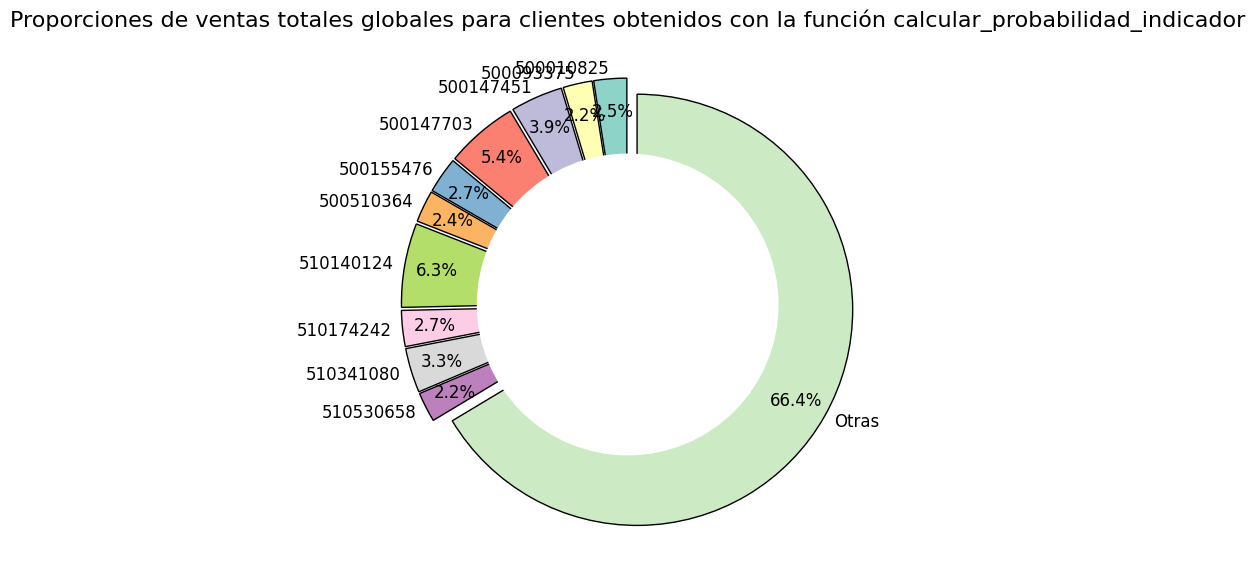

In [ ]:
# Realizar el gráfico de pastel de las proporciones de ventas totales globales para clientes obtenidos mediante la función calcular_probabilidad_indicador

grafica_pastel_clientes(resultado, "Proporciones de ventas totales globales para clientes obtenidos con la función calcular_probabilidad_indicador")

## Gráfica de proporciones de ventas totales de clientes con los que se compararon los clientes anteriores durante los últimos 6 meses de información

In [ ]:
# Convertir los datos de los clientes en común en un dataframe para su posterior procesamiento

customer_ids_comunes = pd.DataFrame(list(customer_ids_comunes), columns=["CustomerId"])

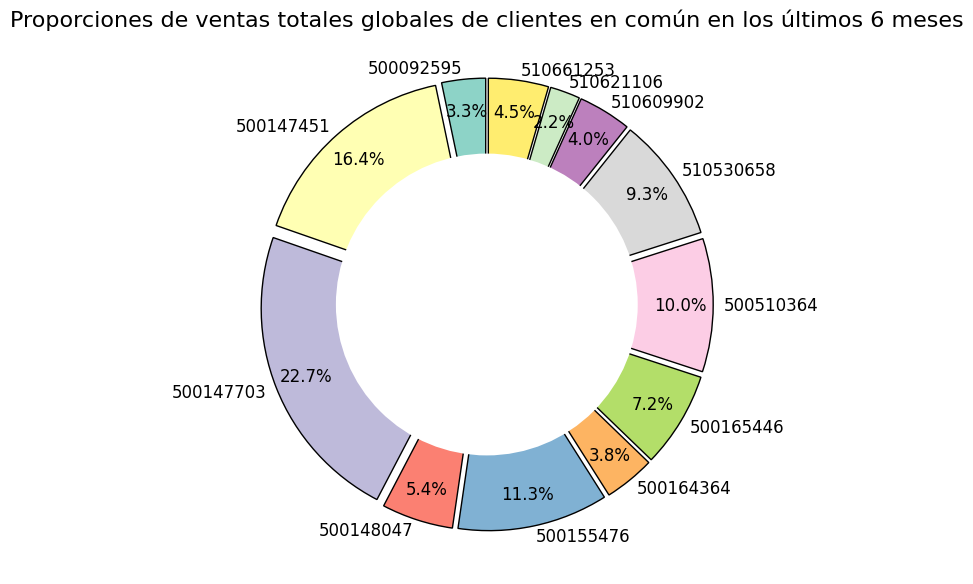

In [ ]:
# Realizar el gráfico de pastel para los clientes con los que se compararon los clientes previos en los últimos 6 meses de información

grafica_pastel_clientes(customer_ids_comunes, "Proporciones de ventas totales globales de clientes en común en los últimos 6 meses")

In [ ]:
def top_10_clientes_pastel(df_ventas, titulo):
    # Calcular las ventas totales globales por cliente
    ventas_por_cliente = df_ventas.groupby('CustomerId')['uni_box'].sum()

    # Ordenar por ventas totales en orden descendente y seleccionar los 10 primeros clientes
    top_10_ventas = ventas_por_cliente.sort_values(ascending=False).head(10)

    # Calcular porcentaje de ventas para cada uno de los 10 clientes
    porcentajes = top_10_ventas / top_10_ventas.sum()

    # Crear los colores del gráfico de pastel
    colores = plt.get_cmap('Set3')(range(len(top_10_ventas)))

    # Crear una figura para el gráfico de pastel
    plt.figure(figsize=(10, 7))

    # Configuración del gráfico de pastel
    plt.pie(top_10_ventas, 
            labels=top_10_ventas.index, 
            autopct="%.1f%%", 
            startangle=90, 
            colors=colores, 
            explode=[0.05] * len(top_10_ventas), 
            wedgeprops={'edgecolor': 'black'},
            textprops={'fontsize': 12},
            pctdistance=0.85,  # Colocar porcentajes más próximos al borde
            labeldistance=1.05  # Colocar etiquetas en el exterior
    )

    # Agregar circunferencia en el centro para hacer un gráfico de dona
    centro_circulo = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centro_circulo)

    # Título del gráfico
    plt.title(titulo, fontsize=16)

    # Mostrar el gráfico
    plt.show()


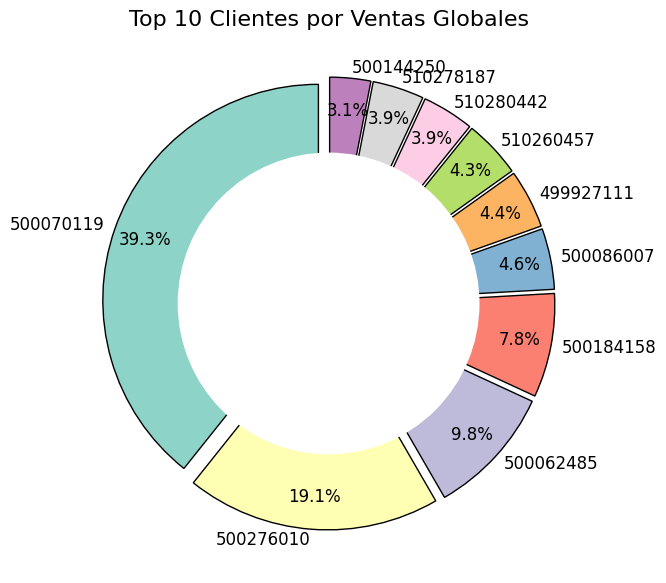

In [ ]:
top_10_clientes_pastel(df_ventas, "Top 10 Clientes por Ventas Globales")

In [68]:
print('\nRandom Forest 4')
rf_model_4 = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=250, min_samples_split=4, class_weight='balanced')
rf_model_4.fit(X_train_scaled, y_train)
test_thresholds(rf_model_4, X_test_scaled, y_test)


Random Forest 4

Umbral: 0.10
Precisión del modelo: 0.80
Precision: 0.47
Recall: 0.94
F1 score: 0.62

Umbral: 0.20
Precisión del modelo: 0.87
Precision: 0.58
Recall: 0.88
F1 score: 0.70

Umbral: 0.30
Precisión del modelo: 0.90
Precision: 0.66
Recall: 0.82
F1 score: 0.73

Umbral: 0.40
Precisión del modelo: 0.91
Precision: 0.73
Recall: 0.75
F1 score: 0.74

Umbral: 0.50
Precisión del modelo: 0.91
Precision: 0.79
Recall: 0.67
F1 score: 0.72

Umbral: 0.60
Precisión del modelo: 0.91
Precision: 0.83
Recall: 0.58
F1 score: 0.68

Umbral: 0.70
Precisión del modelo: 0.90
Precision: 0.87
Recall: 0.48
F1 score: 0.62

Umbral: 0.80
Precisión del modelo: 0.89
Precision: 0.92
Recall: 0.38
F1 score: 0.54

Umbral: 0.90
Precisión del modelo: 0.86
Precision: 0.96
Recall: 0.21
F1 score: 0.34


In [69]:
# Separar las características (X) y la variable objetivo (y)
X = df_final[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y = df_final['Producto Exitoso']  # Variable dependiente

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_scaled = scaler.fit_transform(X)

# Obtener las probabilidades para la clase positiva (clase 1)
y_prob_rf = rf_model_4.predict_proba(X_scaled)[:, 1]  # Selecciona la columna de la clase 1

# Suponiendo que df_test es tu DataFrame original de prueba
df_final['Probabilidad_Indicador'] = y_prob_rf

# Seleccionar las columnas y mostrar las primeras filas
ejemplo = df_final[['CustomerId', 'material', 'Num_productos_distintos', 'ProductType_Original', 'MLSize',
                    'Container_Original', 'mes_inicial', 'Producto Exitoso', 'Probabilidad_Indicador']]

# Mostrar las primeras filas
ejemplo.head(10)

,CustomerId,material,Num_productos_distintos,ProductType_Original,MLSize,Container_Original,mes_inicial,Producto Exitoso,Probabilidad_Indicador
0,499920078,1,147,COLAS REGULAR,355.0,VIDRIO,2,0,0.004971
1,499920078,24,147,SABORES REGULAR,250.0,PLASTICO,1,0,0.023704
2,499920078,100,147,COLAS REGULAR,500.0,VIDRIO,1,1,0.969521
3,499920078,101,147,SABORES REGULAR,500.0,VIDRIO,6,0,0.010629
4,499920078,121,147,SABORES REGULAR,500.0,VIDRIO,1,0,0.000000
5,499920078,127,147,COLAS LIGHT,500.0,VIDRIO,9,0,0.000000
6,499920078,197,147,COLAS REGULAR,500.0,PLASTICO,6,0,0.033192
7,499920078,288,147,COLAS LIGHT,2000.0,PLASTICO,3,0,0.037738
8,499920078,302,147,COLAS LIGHT,2000.0,PLASTICO,6,0,0.049762
9,499920078,312,147,SABORES REGULAR,250.0,PLASTICO,1,0,0.006667


# Revisar un solo producto (Cola regular, 500 ml, vidrio)

In [70]:
df_filtrado = ejemplo[ejemplo['material'] == 100].sort_values(by='Probabilidad_Indicador', ascending=False)

df_filtrado.head(20)

,CustomerId,material,Num_productos_distintos,ProductType_Original,MLSize,Container_Original,mes_inicial,Producto Exitoso,Probabilidad_Indicador
118273,500395050,100,178,COLAS REGULAR,500.0,VIDRIO,1,1,0.999530
110741,500381332,100,159,COLAS REGULAR,500.0,VIDRIO,1,1,0.999283
135242,500429998,100,174,COLAS REGULAR,500.0,VIDRIO,1,1,0.999029
129557,500417987,100,156,COLAS REGULAR,500.0,VIDRIO,1,1,0.999028
126878,500412410,100,198,COLAS REGULAR,500.0,VIDRIO,1,1,0.998849
127479,500413264,100,154,COLAS REGULAR,500.0,VIDRIO,1,1,0.998084
135937,500440905,100,132,COLAS REGULAR,500.0,VIDRIO,1,1,0.997971
3039,499930743,100,171,COLAS REGULAR,500.0,VIDRIO,1,1,0.997810
120691,500398979,100,165,COLAS REGULAR,500.0,VIDRIO,1,1,0.997614
131883,500423341,100,156,COLAS REGULAR,500.0,VIDRIO,1,1,0.997403


In [71]:
df_filtrado.tail(20)

,CustomerId,material,Num_productos_distintos,ProductType_Original,MLSize,Container_Original,mes_inicial,Producto Exitoso,Probabilidad_Indicador
160477,510262187,100,20,COLAS REGULAR,500.0,VIDRIO,6,0,0.043515
160804,510271512,100,132,COLAS REGULAR,500.0,VIDRIO,5,0,0.043515
166414,510313369,100,59,COLAS REGULAR,500.0,VIDRIO,3,0,0.043265
145855,510020475,100,10,COLAS REGULAR,500.0,VIDRIO,12,0,0.043082
193581,510595396,100,67,COLAS REGULAR,500.0,VIDRIO,5,0,0.040172
23039,500032928,100,112,COLAS REGULAR,500.0,VIDRIO,5,0,0.040000
149625,510095402,100,107,COLAS REGULAR,500.0,VIDRIO,2,0,0.039122
101929,500356300,100,25,COLAS REGULAR,500.0,VIDRIO,2,0,0.039020
149476,510094827,100,32,COLAS REGULAR,500.0,VIDRIO,2,0,0.038875
73034,500180311,100,102,COLAS REGULAR,500.0,VIDRIO,8,0,0.033145


# Ejemplo de un nuevo producto introducido

In [72]:
print(df_final.columns)

Index(['index', 'CustomerId', 'material', 'uni_box', 'Fecha', 'mes_1', 'mes_2',
       'mes_3', 'mes_4', 'mes_5',
       ...
       'proporcion_CATEGORIAS EN EXPANSION', 'proporcion_LACTEOS',
       'proporcion_REFRESCOS', 'proporcion_unibox_AGUA',
       'proporcion_unibox_AGUA MINERAL CON SABOR',
       'proporcion_unibox_BEBIDAS CON ALCOHOL',
       'proporcion_unibox_CATEGORIAS EN EXPANSION',
       'proporcion_unibox_LACTEOS', 'proporcion_unibox_REFRESCOS',
       'Probabilidad_Indicador'],
      dtype='object', length=241)


In [73]:
clientes = df_final[['CustomerId', 'material', 'uni_box', 'Fecha', 'Producto Exitoso',
       'pob_ab_300m', 'pob_cmas_300m', 'pob_c_300m', 'pob_cmen_300m',
       'pob_dmas_300m', 'pob_d_300m', 'pob_e_300m', 'parques', 'supermercados',
       'hospitales', 'gimnasios', 'industry_customer_size', 'instituciones', 'infancia_0_11', 'adolescencia_12_17',
       'joven_Adulto_18_29', 'adulto_30_49', 'adulto_mayor_50_mas',
       'hogar_familiar_conteo', 'hogar_familiar_no_conteo',
       'Abarrotes_Almacenes_Bodegas_Viveres', 'Carniceria_Polleria_Pescaderia',
       'Cerveza_y_Licores', 'Estanquillos_kioscos', 'Farmacia_Independiente',
       'Frutas_y_Verduras', 'Hogar_con_Venta', 'Mayorista_Abarrotero',
       'Minisuper_Minimarket', 'Panaderia_Pasteleria',
       'TDC_Proximidad_Independiente',
       'Tiendas_de_Alimentos_Especializados_Organicos', 'Tortilleria', 'Num_productos_distintos',
        'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
        'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12', 'Cluster']].copy()

# Eliminar duplicados basados en la columna 'CustomerId'
clientes_unicos = clientes.drop_duplicates(subset='CustomerId', keep='first')

# Resetear el índice del DataFrame
clientes_unicos = clientes_unicos.reset_index(drop=True)

# Separar las características (X) y la variable objetivo (y)
X = df_entrenamiento[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


y = df_entrenamiento['Producto Exitoso']  # Variable dependiente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba (usando los parámetros ajustados en el conjunto de entrenamiento)
X_test_scaled = scaler.transform(X_test)

In [74]:
import pandas as pd

# Opciones para el tipo de empaque
opciones_empaque = ['bolsa', 'lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio']

# Opciones para el tipo de bebida (en minúsculas)
opciones_bebidas = {
    'agua funcional': 'AGUA_FUNCIONAL',
    'agua mineral': 'AGUA_MINERAL',
    'agua purificada': 'AGUA_PURIFICADA',
    'agua saborizada': 'AGUA_SABORIZADA',
    'bebida alcoholica': 'BEBIDA_ALCOHOLICA',
    'bebidas de soya': 'BEBIDAS_DE_SOYA',
    'bebidas energeticas': 'BEBIDAS_ENERGETICAS',
    'bebidas infantiles': 'BEBIDAS_INFANTILES',
    'bebidas refrescantes': 'BEBIDAS_REFRESCANTES',
    'cafe grano': 'CAFE_GRANO',
    'cafe molido': 'CAFE_MOLIDO',
    'colas light': 'COLAS_LIGHT',
    'colas regular': 'COLAS_REGULAR',
    'isotonicos': 'ISOTONICOS',
    'jugos y nectares': 'JUGOS_Y_NECTARES',
    'leche uht especializada': 'LECHE_UHT_ESPECIALIZADA',
    'leche uht regular': 'LECHE_UHT_REGULAR',
    'leche uht saborizada': 'LECHE_UHT_SABORIZADA',
    'mixtos': 'MIXTOS',
    'naranjadas': 'NARANJADAS',
    'sabores light': 'SABORES_LIGHT',
    'sabores regular': 'SABORES_REGULAR',
    'te': 'TE'
}

# Opciones para el tipo de bebida (en minúsculas)
opciones_mes = {
    'enero': 'mes_inicial_1',
    'febrero': 'mes_inicial_2',
    'marzo': 'mes_inicial_3',
    'abril': 'mes_inicial_4',
    'mayo': 'mes_inicial_5',
    'junio': 'mes_inicial_6',
    'julio': 'mes_inicial_7',
    'agosto': 'mes_inicial_8',
    'septiembre': 'mes_inicial_9',
    'octubre': 'mes_inicial_10',
    'noviembre': 'mes_inicial_11',
    'diciembre': 'mes_inicial_12'
}

# 1. Pedir al usuario el tamaño MLSize
MLSize = float(input("Ingrese el tamaño del producto (MLSize): "))

# 2. Preguntar por el tipo de empaque
empaque = input(f"Seleccione el tipo de empaque entre las opciones {opciones_empaque}: ").lower()

# 3. Preguntar por el tipo de bebida
bebida = input(f"Seleccione el tipo de bebida entre las opciones {list(opciones_bebidas.keys())}: ").lower()

# 4. Preguntar por el mes de introducción
mes = input(f"Seleccione el mes a introducir el producto {list(opciones_mes.keys())}: ").lower()

# Inicializar las columnas de empaque y bebidas con 0
data_empaque = {opcion: 0 for opcion in opciones_empaque}
data_bebidas = {columna: 0 for columna in opciones_bebidas.values()}
data_mes = {columna: 0 for columna in opciones_mes.values()}

# Poner 1 en la columna correspondiente al empaque seleccionado
if empaque in data_empaque:
    data_empaque[empaque] = 1
else:
    print("Opción de empaque no válida.")

# Poner 1 en la columna correspondiente a la bebida seleccionada
if bebida in opciones_bebidas:
    data_bebidas[opciones_bebidas[bebida]] = 1
else:
    print("Opción de bebida no válida.")
    
if mes in opciones_mes:
    data_mes[opciones_mes[mes]] = 1
else:
    print("Opción de mes no válida.")

# Combinar MLSize, empaque, y bebida en un solo diccionario
data = {'MLSize': [MLSize]}  # Colocamos MLSize como primer dato
data.update({key: [value] for key, value in data_empaque.items()})  # Añadir empaque
data.update({key: [value] for key, value in data_bebidas.items()})  # Añadir bebida
data.update({key: [value] for key, value in data_mes.items()})  # Añadir mes

# Crear un DataFrame con los datos
df_registro = pd.DataFrame(data)

# Repetir el valor de df_registro tantas veces como filas en df_principal
df_registro_replicado = pd.concat([df_registro]*len(clientes_unicos), ignore_index=True)

# Concatenar ambos DataFrames por columnas
df_ejemplo = pd.concat([clientes_unicos, df_registro_replicado], axis=1)

df_ejemplo = df_ejemplo.dropna()

# Separar las características (X) y la variable objetivo (y)
X = df_ejemplo[['MLSize', 'mes_1', 'mes_2', 'mes_3','mes_4', 'mes_5', 'mes_6',
              'mes_7', 'mes_8', 'mes_9', 'mes_10','mes_11', 'mes_12',
              'mes_inicial_1', 'mes_inicial_2', 'mes_inicial_3', 'mes_inicial_4',
              'mes_inicial_5', 'mes_inicial_6', 'mes_inicial_7', 'mes_inicial_8',
              'mes_inicial_9', 'mes_inicial_10', 'mes_inicial_11', 'mes_inicial_12',
              'bolsa','lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio',
              'AGUA_FUNCIONAL', 'AGUA_MINERAL', 'AGUA_PURIFICADA', 'AGUA_SABORIZADA',
              'BEBIDA_ALCOHOLICA', 'BEBIDAS_DE_SOYA', 'BEBIDAS_ENERGETICAS',
              'BEBIDAS_INFANTILES', 'BEBIDAS_REFRESCANTES', 'CAFE_GRANO',
              'CAFE_MOLIDO', 'COLAS_LIGHT', 'COLAS_REGULAR', 'ISOTONICOS',
              'JUGOS_Y_NECTARES', 'LECHE_UHT_ESPECIALIZADA', 'LECHE_UHT_REGULAR',
              'LECHE_UHT_SABORIZADA', 'MIXTOS', 'NARANJADAS', 'SABORES_LIGHT',
              'SABORES_REGULAR', 'TE',
              'Num_productos_distintos', 'uni_box']]  # Variables independientes


# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
# X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)

# Entrenar el modelo solo una vez
rf_model_4.fit(X_train_scaled, y_train)

# Cuando realices predicciones, solo utiliza transform
X_scaled = scaler.transform(X)  # Escalar las nuevas características

# Obtener las probabilidades para la clase positiva (clase 1)
y_prob_rf = rf_model_4.predict_proba(X_scaled)[:, 1]  # Selecciona la columna de la clase 1

# Suponiendo que df_test es tu DataFrame original de prueba
df_ejemplo['Probabilidad_Indicador'] = y_prob_rf

# Seleccionar las columnas y ordenar el DataFrame por 'Probabilidad_Indicador' de mayor a menor
ejemplo = df_ejemplo[['CustomerId', 'Probabilidad_Indicador']].sort_values(by='Probabilidad_Indicador', ascending=False)

# Mostrar las primeras filas del DataFrame ordenado
print(ejemplo.head(20))

      CustomerId  Probabilidad_Indicador
1777   510652644                0.969489
1642   510540443                0.885475
1780   510655461                0.883926
497    500147703                0.871321
413    500115586                0.864191
1684   510572570                0.863305
1766   510642970                0.861552
1443   510339030                0.860801
1603   510499162                0.860478
1729   510611899                0.858238
1789   510661253                0.856890
423    500118938                0.856287
1538   510424128                0.856066
1616   510522563                0.853961
329    500091885                0.844933
196    500038628                0.841944
1572   510464967                0.834166
1791   510663402                0.832814
1136   500509918                0.832682
336    500093375                0.831364


In [75]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def calcular_probabilidad_indicador(MLSize, empaque, bebida, mes, clientes_unicos, rf_model, X_train, y_train):
    # Opciones para el tipo de empaque
    opciones_empaque = ['bolsa', 'lata', 'lata sleek', 'plasticos', 'tetra pack', 'vidrio']

    # Opciones para el tipo de bebida
    opciones_bebidas = {
        'agua funcional': 'AGUA_FUNCIONAL',
        'agua mineral': 'AGUA_MINERAL',
        'agua purificada': 'AGUA_PURIFICADA',
        'agua saborizada': 'AGUA_SABORIZADA',
        'bebida alcoholica': 'BEBIDA_ALCOHOLICA',
        'bebidas de soya': 'BEBIDAS_DE_SOYA',
        'bebidas energeticas': 'BEBIDAS_ENERGETICAS',
        'bebidas infantiles': 'BEBIDAS_INFANTILES',
        'bebidas refrescantes': 'BEBIDAS_REFRESCANTES',
        'cafe grano': 'CAFE_GRANO',
        'cafe molido': 'CAFE_MOLIDO',
        'colas light': 'COLAS_LIGHT',
        'colas regular': 'COLAS_REGULAR',
        'isotonicos': 'ISOTONICOS',
        'jugos y nectares': 'JUGOS_Y_NECTARES',
        'leche uht especializada': 'LECHE_UHT_ESPECIALIZADA',
        'leche uht regular': 'LECHE_UHT_REGULAR',
        'leche uht saborizada': 'LECHE_UHT_SABORIZADA',
        'mixtos': 'MIXTOS',
        'naranjadas': 'NARANJADAS',
        'sabores light': 'SABORES_LIGHT',
        'sabores regular': 'SABORES_REGULAR',
        'te': 'TE'
    }

    # Opciones para el mes
    opciones_mes = {
        'enero': 'mes_inicial_1',
        'febrero': 'mes_inicial_2',
        'marzo': 'mes_inicial_3',
        'abril': 'mes_inicial_4',
        'mayo': 'mes_inicial_5',
        'junio': 'mes_inicial_6',
        'julio': 'mes_inicial_7',
        'agosto': 'mes_inicial_8',
        'septiembre': 'mes_inicial_9',
        'octubre': 'mes_inicial_10',
        'noviembre': 'mes_inicial_11',
        'diciembre': 'mes_inicial_12'
    }

    # Inicializar las columnas de empaque, bebidas y mes con 0
    data_empaque = {opcion: 0 for opcion in opciones_empaque}
    data_bebidas = {columna: 0 for columna in opciones_bebidas.values()}
    data_mes = {columna: 0 for columna in opciones_mes.values()}

    # Asignar 1 a las selecciones válidas
    if empaque in data_empaque:
        data_empaque[empaque] = 1
    if bebida in opciones_bebidas:
        data_bebidas[opciones_bebidas[bebida]] = 1
    if mes in opciones_mes:
        data_mes[opciones_mes[mes]] = 1

    # Combinar MLSize, empaque, y bebida en un solo diccionario
    data = {'MLSize': [MLSize]}  # Colocamos MLSize como primer dato
    data.update({key: [value] for key, value in data_empaque.items()})  # Añadir empaque
    data.update({key: [value] for key, value in data_bebidas.items()})  # Añadir bebida
    data.update({key: [value] for key, value in data_mes.items()})  # Añadir mes

    # Crear un DataFrame con los datos
    df_registro = pd.DataFrame(data)

    # Repetir el valor de df_registro tantas veces como filas en clientes_unicos
    df_registro_replicado = pd.concat([df_registro] * len(clientes_unicos), ignore_index=True)

    # Concatenar ambos DataFrames por columnas
    df_ejemplo = pd.concat([clientes_unicos.reset_index(drop=True), df_registro_replicado], axis=1)
    df_ejemplo = df_ejemplo.dropna()

    # Crear una instancia de MinMaxScaler y escalar los datos de entrenamiento
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Entrenar el modelo solo una vez
    rf_model.fit(X_train_scaled, y_train)

    # Asegurar que las columnas coincidan con X_train
    for col in X_train.columns:
        if col not in df_ejemplo.columns:
            df_ejemplo[col] = 0  # Agregar columnas faltantes con valor 0
    X = df_ejemplo[X_train.columns]

    # Transformar las características escaladas
    X_scaled = scaler.transform(X)

    # Obtener las probabilidades para la clase positiva (clase 1)
    y_prob_rf = rf_model.predict_proba(X_scaled)[:, 1]  # Seleccionar la probabilidad de la clase positiva

    # Agregar las probabilidades al DataFrame
    df_ejemplo['Probabilidad_Indicador'] = y_prob_rf

    # Seleccionar y ordenar por probabilidad
    ejemplo = df_ejemplo[['CustomerId', 'Probabilidad_Indicador']].sort_values(by='Probabilidad_Indicador', ascending=False)

    return ejemplo.head(100)



# Insights 

In [76]:
# Agrupar por la columna 'material' y combinar las listas de fechas
df_grouped = df_final.groupby('material', as_index=False).agg({
    'Fecha': lambda x: [fecha for sublist in x for fecha in sublist],
    'ProductType': 'first',
    'MLSize': 'first',
    'Container': 'first',
    'ProductCategory': 'count'

})

# Mostrar el resultado
print("DataFrame agrupado por 'material' con listas de fechas combinadas:")
df_grouped.head()


DataFrame agrupado por 'material' con listas de fechas combinadas:


,material,Fecha,ProductType,MLSize,Container,ProductCategory
0,1,"[2020-02-01 00:00:00, 2020-09-01 00:00:00, 202...",COLAS REGULAR,355.0,VIDRIO,757
1,2,"[2020-07-01 00:00:00, 2022-03-01 00:00:00, 202...",COLAS LIGHT,355.0,VIDRIO,234
2,3,"[2021-08-01 00:00:00, 2021-09-01 00:00:00, 202...",SABORES REGULAR,355.0,VIDRIO,91
3,4,"[2021-07-01 00:00:00, 2021-05-01 00:00:00, 202...",SABORES REGULAR,355.0,VIDRIO,128
4,6,"[2020-03-01 00:00:00, 2020-05-01 00:00:00, 202...",SABORES REGULAR,355.0,VIDRIO,2


In [77]:
# Convertir cada lista de fechas en la columna 'Fecha' a objetos datetime
df_grouped['Fecha'] = df_grouped['Fecha'].apply(lambda x: [pd.to_datetime(date) for date in x])

# Obtener la primera fecha de cada lista en 'Fecha' para cada material
df_grouped['Primera_Fecha'] = df_grouped['Fecha'].apply(lambda x: min(x))

# Definir el rango de fechas para mediados de 2022
inicio_mediados_2022 = pd.to_datetime("2022-06-01")
fin_mediados_2022 = pd.to_datetime("2022-08-31")

# Filtrar materiales cuya primera fecha esté en el rango de mediados de 2022
materiales_mediados_2022 = df_grouped[(df_grouped['Primera_Fecha'] >= inicio_mediados_2022) & 
                                    (df_grouped['Primera_Fecha'] <= fin_mediados_2022)]

# Eliminar duplicados basados en el identificador único del material, conservando toda la información
materiales_mediados_2022 = materiales_mediados_2022.drop_duplicates(subset=['material'])

# Mostrar toda la información de los materiales seleccionados
print("Información de los materiales cuya primera fecha global fue a mediados de 2022:")
materiales_mediados_2022


Información de los materiales cuya primera fecha global fue a mediados de 2022:


,material,Fecha,ProductType,MLSize,Container,ProductCategory,Primera_Fecha
15,26,"[2022-07-01 00:00:00, 2022-08-01 00:00:00, 202...",SABORES REGULAR,250.0,PLASTICO,103,2022-07-01
52,320,"[2022-08-01 00:00:00, 2022-09-01 00:00:00, 202...",COLAS REGULAR,2000.0,PLASTICO,18,2022-07-01
354,4819,[2022-06-01 00:00:00],LECHE UHT REGULAR,1000.0,TETRA PACK,1,2022-06-01
396,5859,[2022-07-01 00:00:00],SABORES LIGHT,600.0,PLASTICO,1,2022-07-01
585,14254,"[2022-06-01 00:00:00, 2022-08-01 00:00:00]",LECHE UHT SABORIZADA,750.0,TETRA PACK,2,2022-06-01
662,14460,[2022-07-01 00:00:00],LECHE UHT REGULAR,750.0,TETRA PACK,1,2022-07-01
695,14526,"[2022-06-01 00:00:00, 2022-06-01 00:00:00, 202...",CAFE MOLIDO,0.0,BOLSA,214,2022-06-01
696,14528,"[2022-07-01 00:00:00, 2022-07-01 00:00:00]",CAFE MOLIDO,0.0,BOLSA,2,2022-07-01
697,14530,"[2022-08-01 00:00:00, 2022-07-01 00:00:00, 202...",CAFE MOLIDO,0.0,BOLSA,96,2022-06-01
698,14532,[2022-08-01 00:00:00],CAFE MOLIDO,0.0,BOLSA,1,2022-08-01


In [78]:
producto = df_prueba[df_prueba['material'] == 14587]
producto

,CustomerId,material,uni_box,Fecha,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,...,proporcion_CATEGORIAS EN EXPANSION,proporcion_LACTEOS,proporcion_REFRESCOS,proporcion_unibox_AGUA,proporcion_unibox_AGUA MINERAL CON SABOR,proporcion_unibox_BEBIDAS CON ALCOHOL,proporcion_unibox_CATEGORIAS EN EXPANSION,proporcion_unibox_LACTEOS,proporcion_unibox_REFRESCOS,grupo
2005,499925720,14587,0.3751,[2022-08-01 00:00:00],0.000000,0.006458,0.236778,0.596988,0.618203,0.598585,...,0.380952,0.047619,0.440476,0.036017,0.000588,0.000000,0.061608,0.001548,0.900239,prueba
3078,499929899,14587,0.3751,[2022-08-01 00:00:00],0.025773,0.000000,0.258612,0.429539,0.235670,0.428893,...,0.325397,0.055556,0.500000,0.051513,0.000607,0.000000,0.068165,0.002150,0.877564,prueba
3588,499930861,14587,0.3751,[2022-08-01 00:00:00],0.175452,0.000000,0.557784,0.916186,1.000000,0.698843,...,0.386555,0.054622,0.420168,0.070932,0.002933,0.000265,0.083074,0.006629,0.836168,prueba
3929,499932420,14587,0.3751,[2022-08-01 00:00:00],0.328874,0.000000,0.295258,0.607134,1.000000,0.818228,...,0.359712,0.057554,0.438849,0.031879,0.000094,0.000000,0.022740,0.001117,0.944170,prueba
5430,499968994,14587,0.7502,"[2022-08-01 00:00:00, 2022-10-01 00:00:00]",0.414736,0.000000,0.399795,0.461608,0.822845,0.771613,...,0.353448,0.064655,0.439655,0.091813,0.001300,0.000619,0.142789,0.015759,0.747719,prueba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221611,510766660,14587,0.3751,[2022-08-01 00:00:00],0.000000,0.000000,0.000000,0.000000,0.071011,0.798199,...,0.490909,0.072727,0.354545,0.040722,0.000397,0.000000,0.119211,0.007291,0.832379,prueba
222168,510776089,14587,0.3751,[2022-08-01 00:00:00],0.000000,0.000000,0.000000,0.000000,0.000000,0.678298,...,0.358209,0.029851,0.537313,0.043707,0.000000,0.000000,0.037582,0.002929,0.915782,prueba
222209,510777635,14587,0.3751,[2022-11-01 00:00:00],0.000000,0.000000,0.000000,0.000000,0.000000,0.395263,...,0.475000,0.100000,0.350000,0.037979,0.000000,0.000000,0.036094,0.001537,0.924390,prueba
222381,510780352,14587,0.3751,[2022-11-01 00:00:00],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.382716,0.000000,0.543210,0.022158,0.000000,0.000169,0.084929,0.000000,0.892744,prueba


In [79]:
# Llamada al cálculo
resultado = calcular_probabilidad_indicador(
    MLSize=355,
    empaque='lata',
    bebida='colas light',
    mes='septiembre',
    clientes_unicos=clientes_unicos,
    rf_model=rf_model_4,
    X_train=X_train,
    y_train=y_train
)

print(resultado)


      CustomerId  Probabilidad_Indicador
1579   510467928                0.671028
1277   510140124                0.629703
1140   500510580                0.620472
109    500017633                0.619026
1642   510540443                0.616472
...          ...                     ...
1179   509948623                0.519604
532    500162777                0.519542
1651   510546066                0.519319
1309   510210979                0.519270
1233   510089641                0.517942

[100 rows x 2 columns]


In [80]:
# Obtener los CustomerId únicos de ambos DataFrames
customer_ids_resultado = set(resultado['CustomerId'])
customer_ids_producto = set(producto['CustomerId'])

# Encontrar la intersección de CustomerId
customer_ids_comunes = customer_ids_resultado.intersection(customer_ids_producto)

# Contar la cantidad de CustomerId comunes
cantidad_comunes = len(customer_ids_comunes)

print(f"Cantidad de 'CustomerId' que coinciden en ambos DataFrames: {cantidad_comunes}")

# Opcional: Mostrar los CustomerId comunes
print("CustomerId comunes:", customer_ids_comunes)


Cantidad de 'CustomerId' que coinciden en ambos DataFrames: 16
CustomerId comunes: {500170368, 510530658, 510661253, 500161817, 500160173, 510609902, 500148047, 510093104, 510621106, 500169939, 500138427, 500101080, 500162777, 500147451, 510438332, 500160639}


## Gráfica de proporciones de ventas totales de clientes obtenidos con la función `calcular_probabilidad_indicador`

In [81]:
# Función para realizar el gráfico de pastel de ventas totales globales de clientes

def grafica_pastel_clientes(datos_clientes, titulo):

    # Función lambda para obtener las ventas totales globales para cada cliente
    calcular_ventas_totales = lambda cliente: df_ventas[df_ventas['CustomerId'] == cliente]['uni_box'].sum()

    # Calcular las ventas totales globales por cada cliente obtenido en la función 
    datos_clientes['ventas_totales_globales'] = datos_clientes['CustomerId'].apply(calcular_ventas_totales)

    # Definir umbral para agrupar categorías pequeñas
    umbral = 0.02 

    # Calcular porcentaje por categoría
    porcentajes = datos_clientes['ventas_totales_globales'] / np.sum(datos_clientes['ventas_totales_globales'])

    # Creación de máscara para detectar categorías de tamaño pequeño
    small = porcentajes < umbral

    # Juntar categorías pequeñas en 1 única categoría
    agrup_small_categories = datos_clientes.copy()
    agrup_small_categories['CustomerId'] = np.where(small, 'Otras', agrup_small_categories['CustomerId'])
    agrup_small_categories = agrup_small_categories.groupby('CustomerId').sum()

    # Creación de los colores del gráfico de pastel
    colores = plt.get_cmap('Set3')(range(len(agrup_small_categories)))

    # Crear una gráfico de dimensiones 10 x 7
    plt.figure(figsize=(10, 7))

    # Configuración del gráfico de pastel con labels fuera del gráfico
    plt.pie(agrup_small_categories['ventas_totales_globales'], 
            labels=agrup_small_categories.index, 
            autopct="%.1f%%", 
            startangle=90, 
            colors=colores, 
            explode=[0.05] * len(agrup_small_categories), 
            wedgeprops={'edgecolor': 'black'},
            textprops={'fontsize': 12},
            pctdistance=0.85,  # Colocar porcentajes más próximos al borde
            labeldistance=1.05  # Colocar labels en el exterior del gráfico
       )

    # Agregar circunferencia en el centro para hacer un gráfico de dona
    centro_circulo = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centro_circulo)

    # Añadir un título principal al gráfico de pastel
    plt.title(titulo, fontsize=16)

    # Mostrar gráfico de pastel resultante
    plt.show()


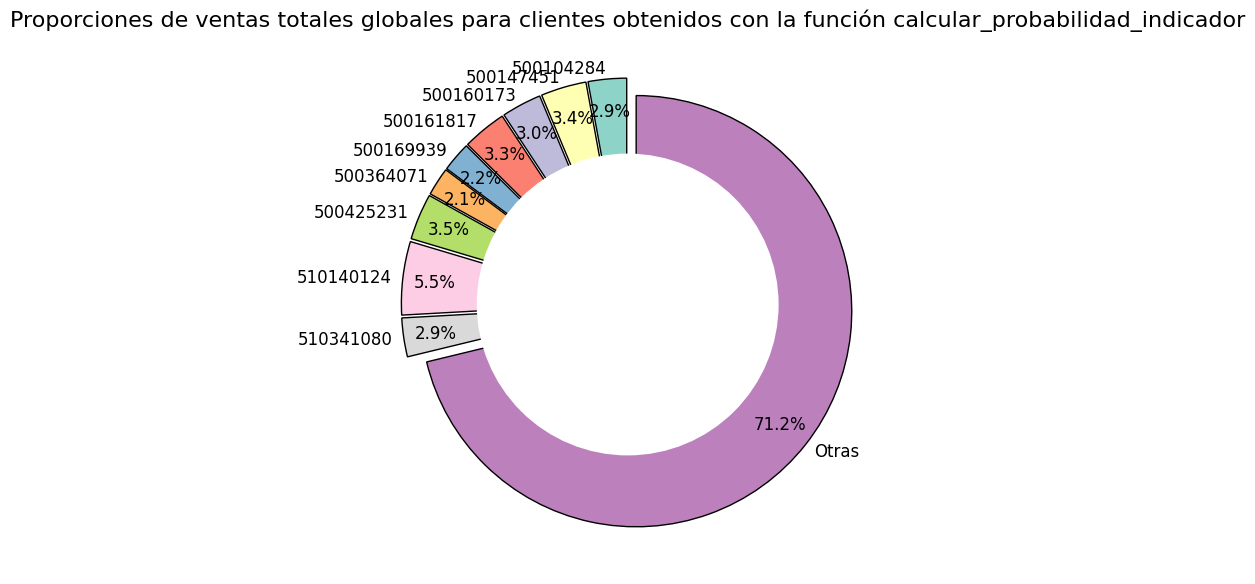

In [82]:
# Realizar el gráfico de pastel de las proporciones de ventas totales globales para clientes obtenidos mediante la función calcular_probabilidad_indicador

grafica_pastel_clientes(resultado, "Proporciones de ventas totales globales para clientes obtenidos con la función calcular_probabilidad_indicador")

## Gráfica de proporciones de ventas totales de clientes con los que se compararon los clientes anteriores durante los últimos 6 meses de información

In [83]:
# Convertir los datos de los clientes en común en un dataframe para su posterior procesamiento

customer_ids_comunes = pd.DataFrame(list(customer_ids_comunes), columns=["CustomerId"])

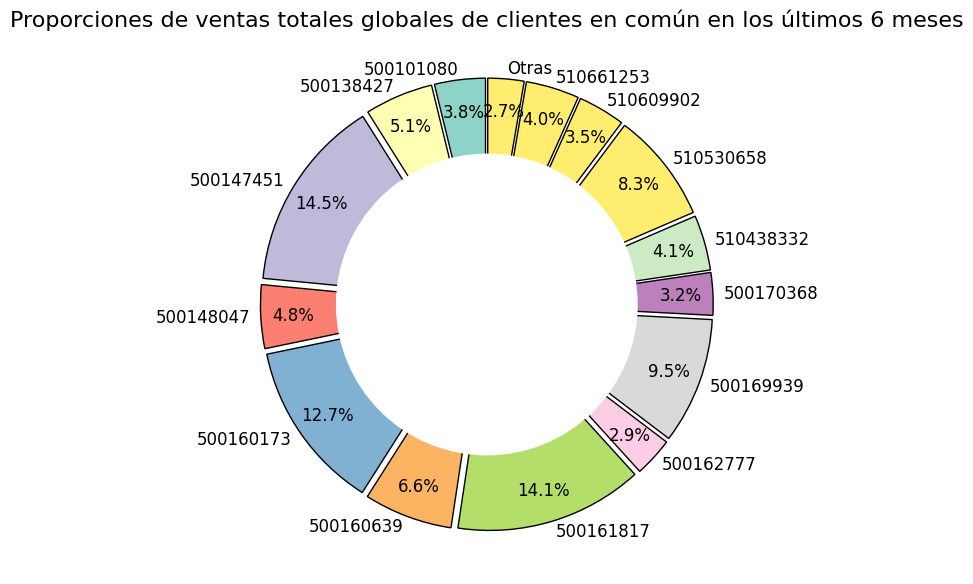

In [84]:
# Realizar el gráfico de pastel para los clientes con los que se compararon los clientes previos en los últimos 6 meses de información

grafica_pastel_clientes(customer_ids_comunes, "Proporciones de ventas totales globales de clientes en común en los últimos 6 meses")

In [85]:
def top_10_clientes_pastel(df_ventas, titulo):
    # Calcular las ventas totales globales por cliente
    ventas_por_cliente = df_ventas.groupby('CustomerId')['uni_box'].sum()

    # Ordenar por ventas totales en orden descendente y seleccionar los 10 primeros clientes
    top_10_ventas = ventas_por_cliente.sort_values(ascending=False).head(10)

    # Calcular porcentaje de ventas para cada uno de los 10 clientes
    porcentajes = top_10_ventas / top_10_ventas.sum()

    # Crear los colores del gráfico de pastel
    colores = plt.get_cmap('Set3')(range(len(top_10_ventas)))

    # Crear una figura para el gráfico de pastel
    plt.figure(figsize=(10, 7))

    # Configuración del gráfico de pastel
    plt.pie(top_10_ventas, 
            labels=top_10_ventas.index, 
            autopct="%.1f%%", 
            startangle=90, 
            colors=colores, 
            explode=[0.05] * len(top_10_ventas), 
            wedgeprops={'edgecolor': 'black'},
            textprops={'fontsize': 12},
            pctdistance=0.85,  # Colocar porcentajes más próximos al borde
            labeldistance=1.05  # Colocar etiquetas en el exterior
    )

    # Agregar circunferencia en el centro para hacer un gráfico de dona
    centro_circulo = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centro_circulo)

    # Título del gráfico
    plt.title(titulo, fontsize=16)

    # Mostrar el gráfico
    plt.show()


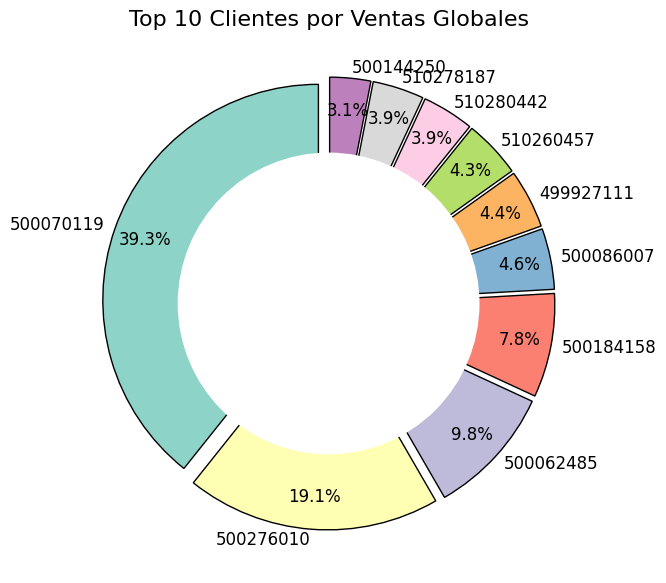

In [86]:
top_10_clientes_pastel(df_ventas, "Top 10 Clientes por Ventas Globales")